In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df = df.dropna()

    df_labels = df.loc[:, df.columns != "Merged"]
    df_labels = df_labels.astype(int)
    df_labels = df_labels.values.tolist()
    df_labels = torch.tensor(df_labels)
    df_labels = df_labels.to(torch.float32)

    df_inputs = df["Merged"].to_list()

    return df_inputs, df_labels

def create_dataloader(path, device, batch_size=1024, shuffle=True, num_workers=0, *args, **kwargs):
    df_inputs, df_labels = load_data(path)

    return torch.utils.data.DataLoader(
        HumanValuesDataset(df_inputs, df_labels, device),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        *args,
        **kwargs
    )

In [6]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.fc1 = torch.nn.Linear(768, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(512, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.dropout4 = torch.nn.Dropout(0.2)
        self.fc5 = torch.nn.Linear(32, 20)
        self.bn5 = torch.nn.BatchNorm1d(20)
        self.dropout5 = torch.nn.Dropout(0.2)
        self.fc6 = torch.nn.Linear(20, 20)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is already encoded, use relu activation
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [7]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

In [8]:
train_loader = create_dataloader("datasets/trainingtest_merged.csv", device)
val_loader = create_dataloader("datasets/validation_merged.csv", device)

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

  0%|          | 0/1200 [00:00<?, ?it/s]

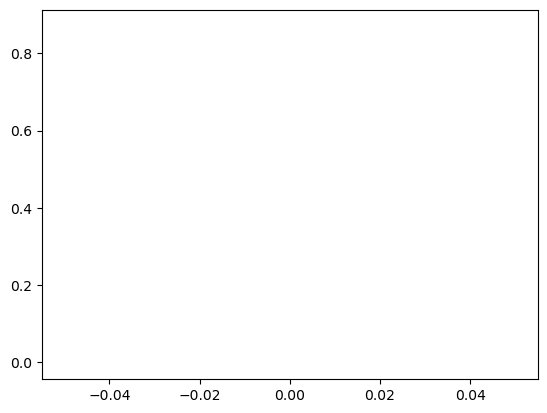

  0%|          | 3/1200 [00:00<01:55, 10.33it/s]

Epoch 1/1200 - loss: 0.8695556124051412, f1: 0.0


  1%|          | 10/1200 [00:02<07:25,  2.67it/s]

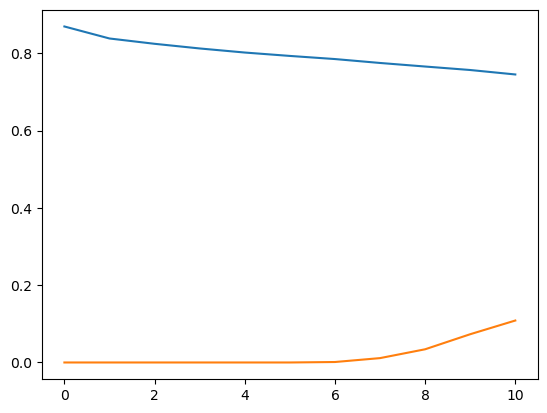

Epoch 11/1200 - loss: 0.7453584770361582, f1: 0.10858280013751054


  2%|▏         | 20/1200 [00:07<06:42,  2.93it/s]

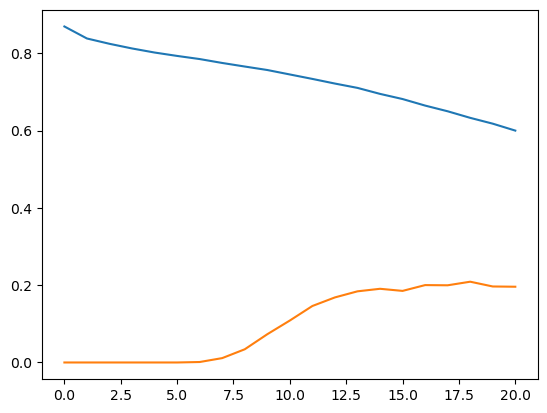

  2%|▏         | 23/1200 [00:07<04:14,  4.63it/s]

Epoch 21/1200 - loss: 0.6000849902629852, f1: 0.19603577429779778


  2%|▏         | 29/1200 [00:07<02:27,  7.93it/s]

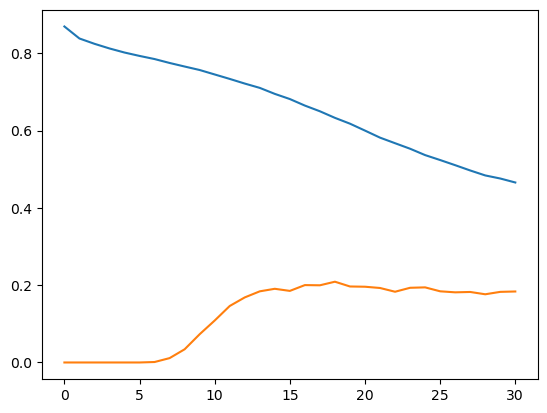

  3%|▎         | 33/1200 [00:08<02:07,  9.17it/s]

Epoch 31/1200 - loss: 0.46580127875010174, f1: 0.18372118128058273


  3%|▎         | 39/1200 [00:08<01:37, 11.95it/s]

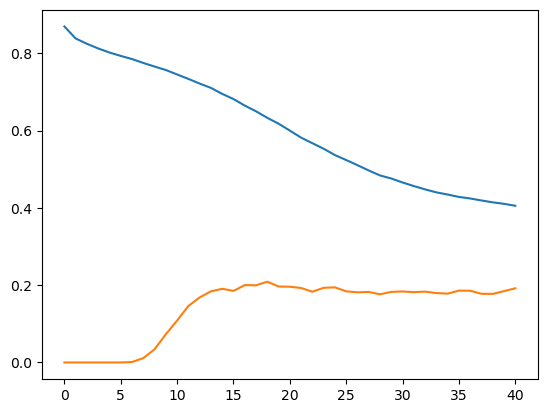

  4%|▎         | 43/1200 [00:09<01:50, 10.46it/s]

Epoch 41/1200 - loss: 0.4055766661961873, f1: 0.19196371601106219


  4%|▍         | 49/1200 [00:09<01:32, 12.46it/s]

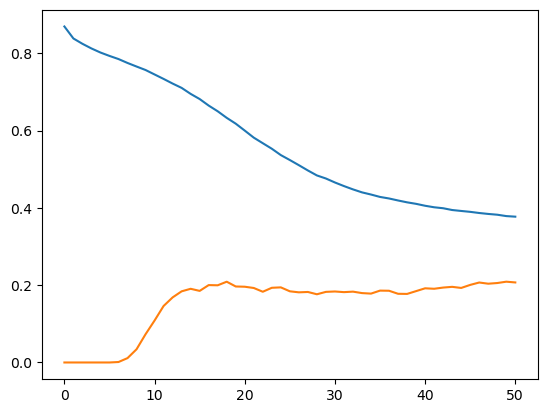

  4%|▍         | 51/1200 [00:10<02:59,  6.42it/s]

Epoch 51/1200 - loss: 0.37734172741572064, f1: 0.20711589853621443


  5%|▌         | 60/1200 [00:14<06:02,  3.14it/s]

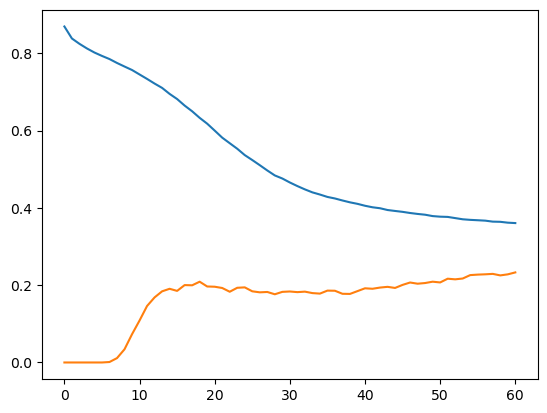

Epoch 61/1200 - loss: 0.3607628295818965, f1: 0.2330909310880399


  6%|▌         | 70/1200 [00:18<05:48,  3.24it/s]

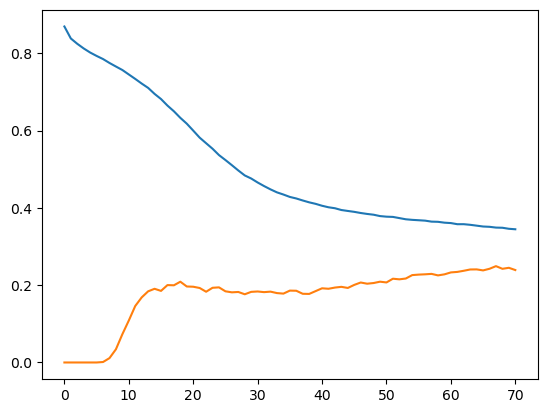

  6%|▌         | 72/1200 [00:18<04:21,  4.32it/s]

Epoch 71/1200 - loss: 0.34474821388721466, f1: 0.23921378110920022


  7%|▋         | 79/1200 [00:20<04:53,  3.82it/s]

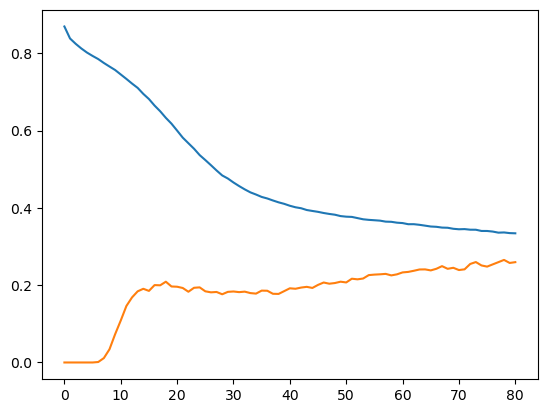

  7%|▋         | 83/1200 [00:21<03:01,  6.15it/s]

Epoch 81/1200 - loss: 0.3342890938123067, f1: 0.25962522801918475


  8%|▊         | 90/1200 [00:23<06:26,  2.87it/s]

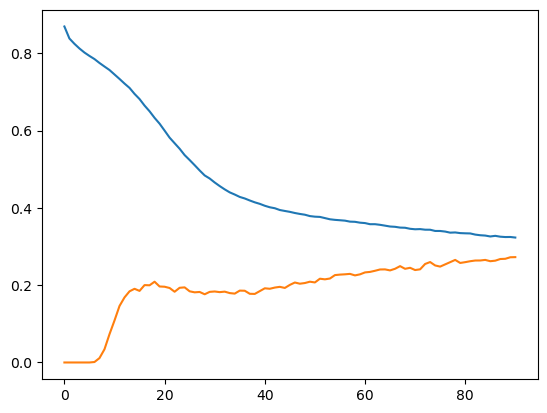

Epoch 91/1200 - loss: 0.32332274317741394, f1: 0.27263105163987117


  8%|▊         | 99/1200 [00:25<04:09,  4.41it/s]

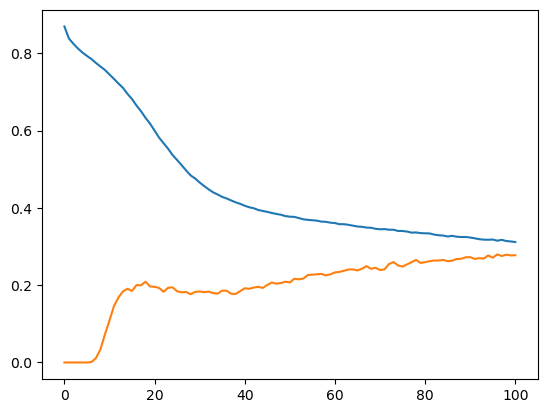

  8%|▊         | 101/1200 [00:25<03:27,  5.29it/s]

Epoch 101/1200 - loss: 0.31174475451310474, f1: 0.27756419979694924


  9%|▉         | 110/1200 [00:28<04:31,  4.02it/s]

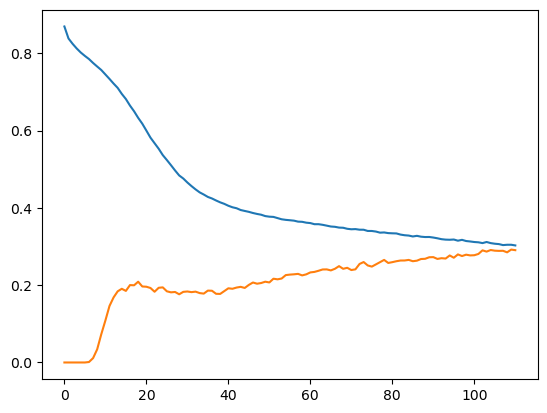

  9%|▉         | 111/1200 [00:28<04:28,  4.06it/s]

Epoch 111/1200 - loss: 0.3029102732737859, f1: 0.290639205922813


 10%|█         | 120/1200 [00:30<03:43,  4.82it/s]

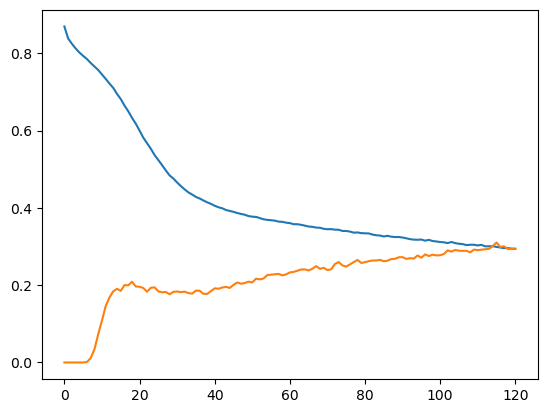

 10%|█         | 122/1200 [00:31<03:06,  5.79it/s]

Epoch 121/1200 - loss: 0.29426582157611847, f1: 0.2941014128298999


 11%|█         | 129/1200 [00:32<03:19,  5.36it/s]

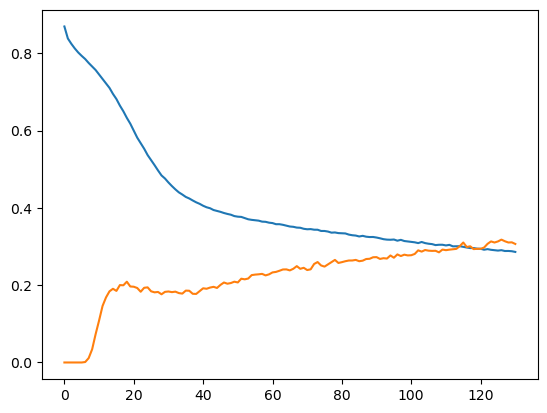

 11%|█         | 133/1200 [00:33<02:22,  7.48it/s]

Epoch 131/1200 - loss: 0.28610021869341534, f1: 0.30674416437056606


 12%|█▏        | 140/1200 [00:34<03:48,  4.65it/s]

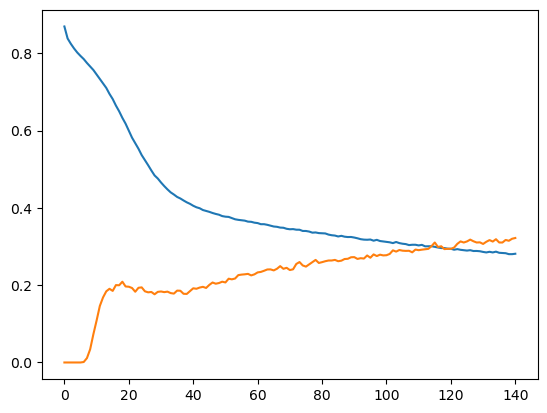

Epoch 141/1200 - loss: 0.28136646499236423, f1: 0.3221618516267884


 12%|█▎        | 150/1200 [00:37<04:13,  4.14it/s]

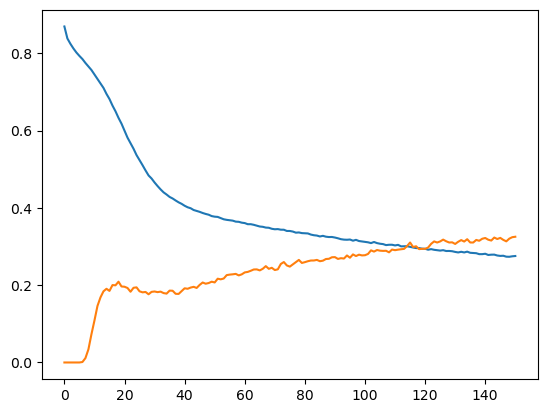

Epoch 151/1200 - loss: 0.27552348623673123, f1: 0.3253731910022269


 13%|█▎        | 159/1200 [00:39<03:50,  4.52it/s]

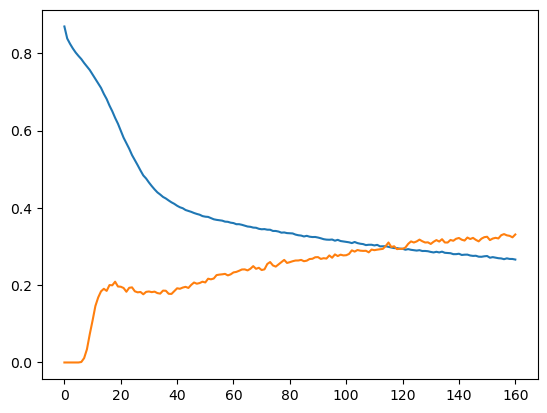

 14%|█▎        | 162/1200 [00:39<03:07,  5.53it/s]

Epoch 161/1200 - loss: 0.26636513819297153, f1: 0.3312529054253438


 14%|█▍        | 170/1200 [00:40<01:44,  9.88it/s]

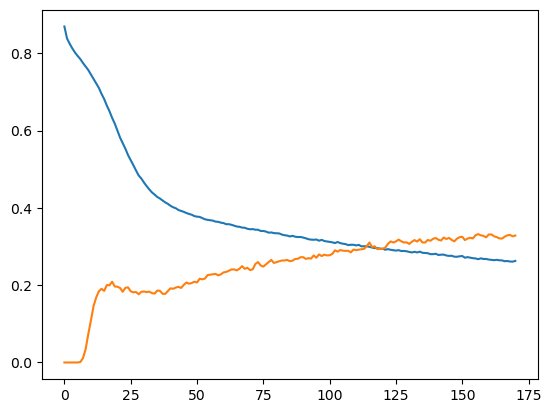

Epoch 171/1200 - loss: 0.2628595679998398, f1: 0.32851712727175336


 15%|█▌        | 180/1200 [00:41<01:44,  9.79it/s]

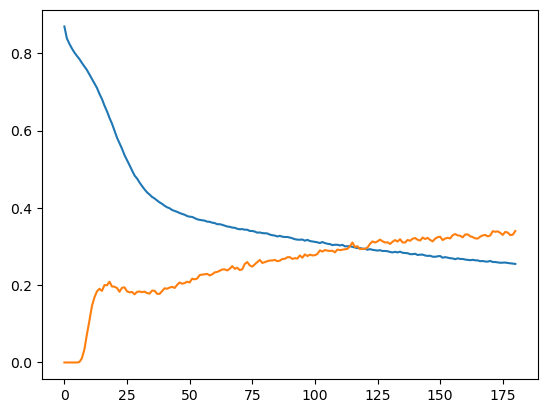

Epoch 181/1200 - loss: 0.2550828456878662, f1: 0.3401023896133907


 16%|█▌        | 189/1200 [00:44<04:26,  3.79it/s]

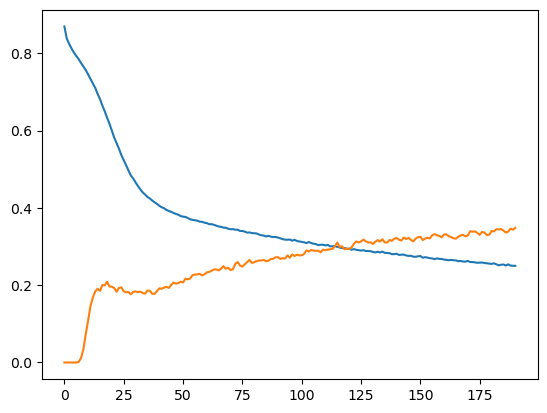

Epoch 191/1200 - loss: 0.25010065734386444, f1: 0.34813959993778604


 17%|█▋        | 199/1200 [00:45<02:02,  8.17it/s]

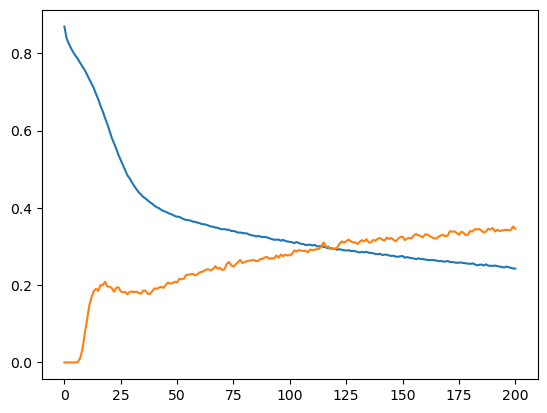

 17%|█▋        | 203/1200 [00:46<02:33,  6.49it/s]

Epoch 201/1200 - loss: 0.24293442567189535, f1: 0.3458889584126338


 17%|█▋        | 209/1200 [00:47<01:55,  8.61it/s]

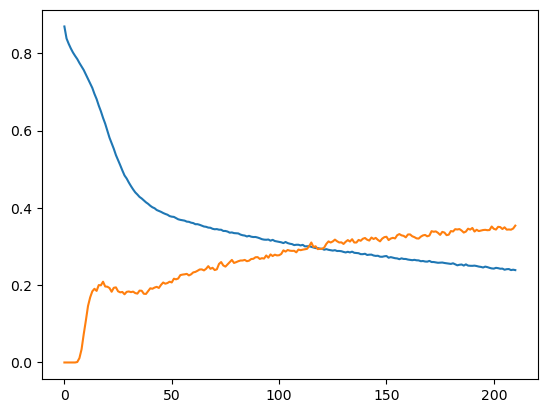

Epoch 211/1200 - loss: 0.23904778560002646, f1: 0.3541425905904472


 18%|█▊        | 220/1200 [00:49<02:02,  8.03it/s]

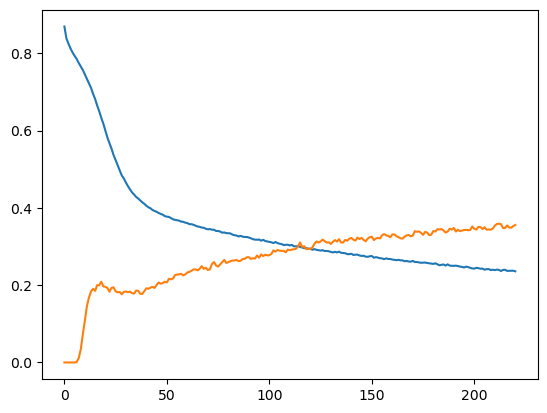

 18%|█▊        | 222/1200 [00:49<01:56,  8.42it/s]

Epoch 221/1200 - loss: 0.23595976829528809, f1: 0.3558781431036377


 19%|█▉        | 230/1200 [00:50<02:24,  6.72it/s]

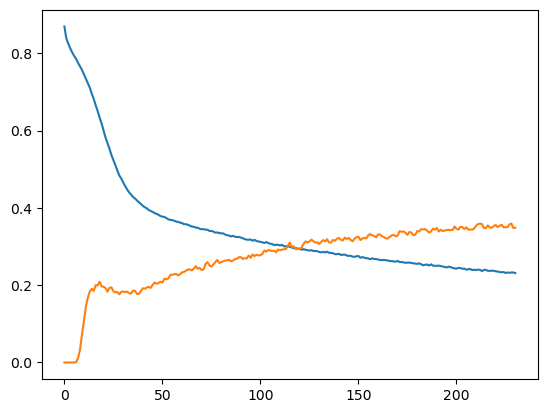

 19%|█▉        | 232/1200 [00:50<02:12,  7.33it/s]

Epoch 231/1200 - loss: 0.2313815802335739, f1: 0.34882592603863694


 20%|██        | 240/1200 [00:52<02:43,  5.89it/s]

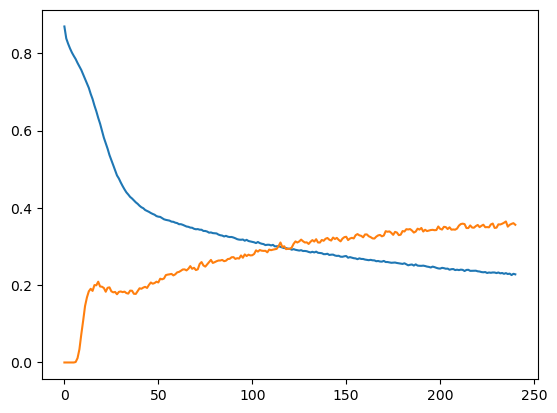

 20%|██        | 242/1200 [00:52<02:27,  6.50it/s]

Epoch 241/1200 - loss: 0.22808358073234558, f1: 0.3563481165234704


 21%|██        | 250/1200 [00:53<01:30, 10.53it/s]

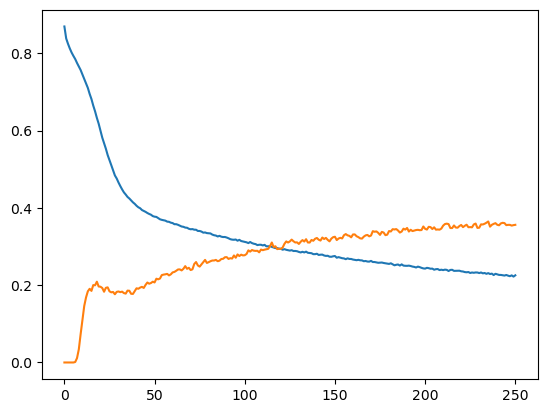

 21%|██        | 252/1200 [00:53<01:32, 10.26it/s]

Epoch 251/1200 - loss: 0.22556539128224054, f1: 0.3562235745982417


 22%|██▏       | 260/1200 [00:54<01:57,  8.00it/s]

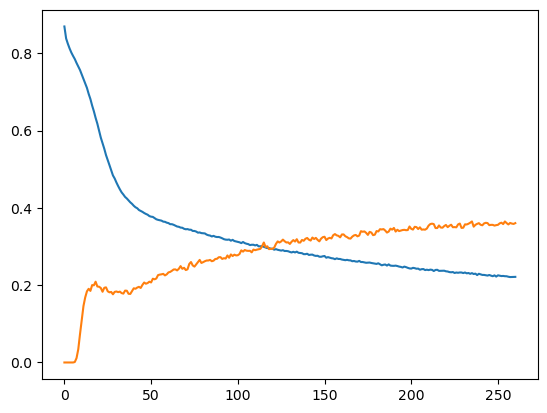

 22%|██▏       | 262/1200 [00:55<01:52,  8.33it/s]

Epoch 261/1200 - loss: 0.2215536137421926, f1: 0.36064777661198233


 22%|██▎       | 270/1200 [00:56<02:16,  6.83it/s]

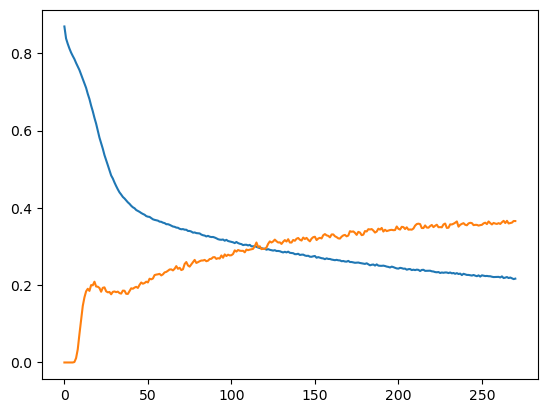

 23%|██▎       | 272/1200 [00:56<02:05,  7.38it/s]

Epoch 271/1200 - loss: 0.21695485462745032, f1: 0.36600541740073755


 23%|██▎       | 280/1200 [00:57<01:58,  7.78it/s]

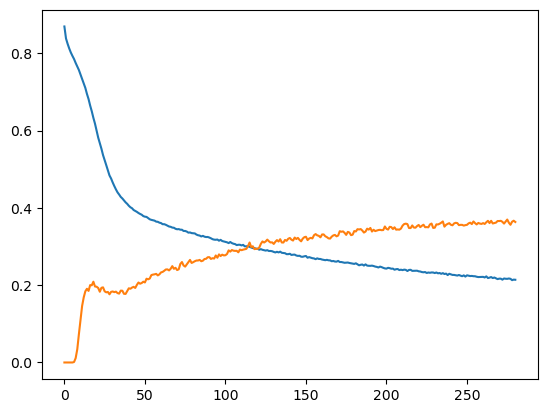

 24%|██▎       | 282/1200 [00:58<02:10,  7.01it/s]

Epoch 281/1200 - loss: 0.21407966564098993, f1: 0.3636239226927157


 24%|██▍       | 290/1200 [00:59<01:57,  7.71it/s]

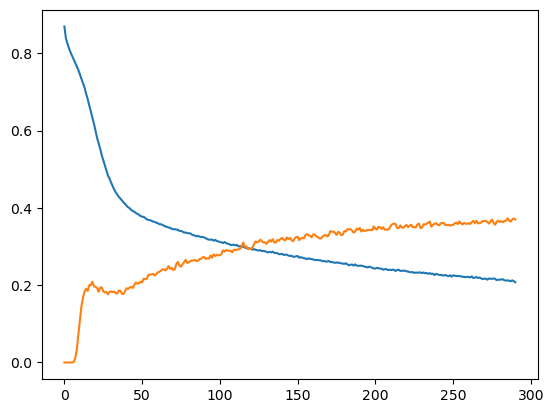

 24%|██▍       | 292/1200 [00:59<01:53,  8.00it/s]

Epoch 291/1200 - loss: 0.2078554779291153, f1: 0.3701240963324055


 25%|██▌       | 300/1200 [01:01<03:26,  4.37it/s]

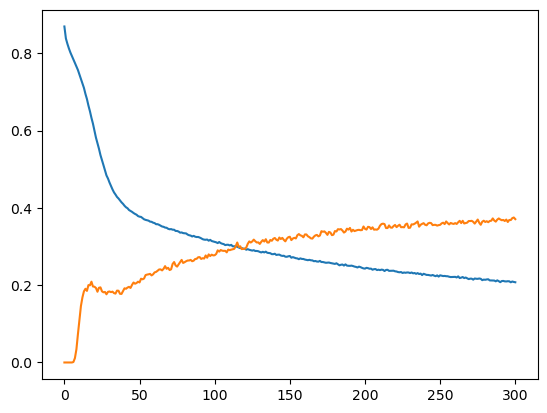

 25%|██▌       | 301/1200 [01:01<03:13,  4.63it/s]

Epoch 301/1200 - loss: 0.20760411520799002, f1: 0.3709634211110006


 26%|██▌       | 310/1200 [01:02<01:57,  7.60it/s]

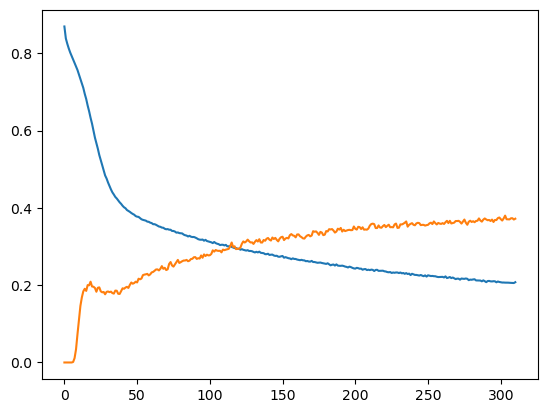

 26%|██▌       | 312/1200 [01:02<01:53,  7.85it/s]

Epoch 311/1200 - loss: 0.20777193705240884, f1: 0.37207397084067056


 27%|██▋       | 320/1200 [01:03<01:20, 10.87it/s]

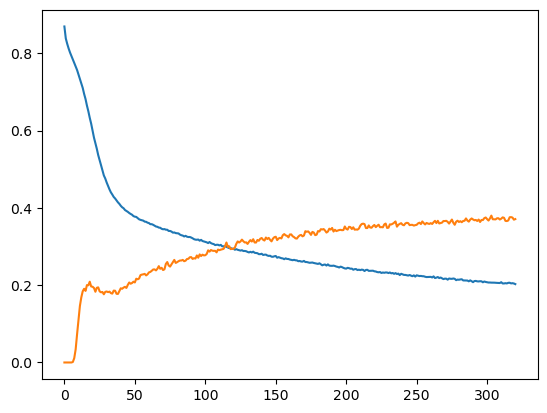

 27%|██▋       | 322/1200 [01:03<01:26, 10.15it/s]

Epoch 321/1200 - loss: 0.20280656963586807, f1: 0.3710686245855491


 28%|██▊       | 330/1200 [01:04<01:24, 10.32it/s]

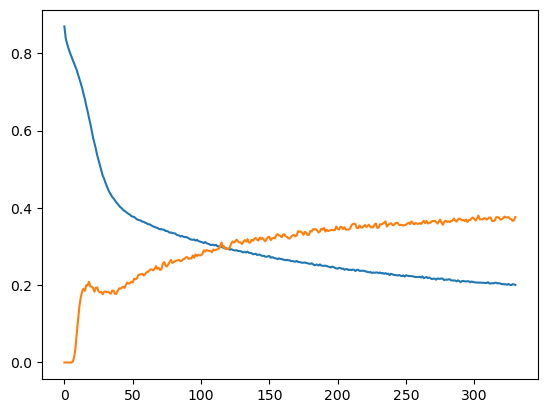

 28%|██▊       | 334/1200 [01:04<01:17, 11.14it/s]

Epoch 331/1200 - loss: 0.2007997383673986, f1: 0.37621326595031435


 28%|██▊       | 340/1200 [01:05<01:10, 12.26it/s]

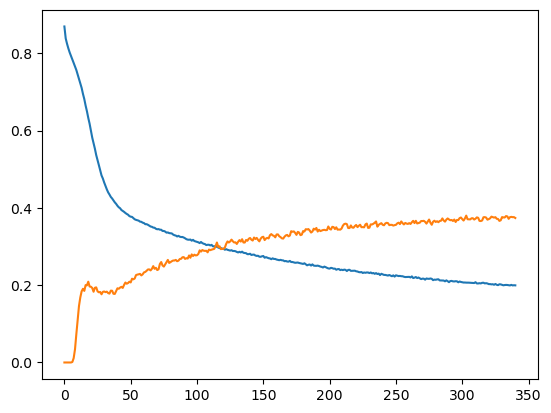

 28%|██▊       | 342/1200 [01:05<01:17, 11.08it/s]

Epoch 341/1200 - loss: 0.19959243883689246, f1: 0.37392143076601075


 29%|██▉       | 350/1200 [01:06<01:26,  9.78it/s]

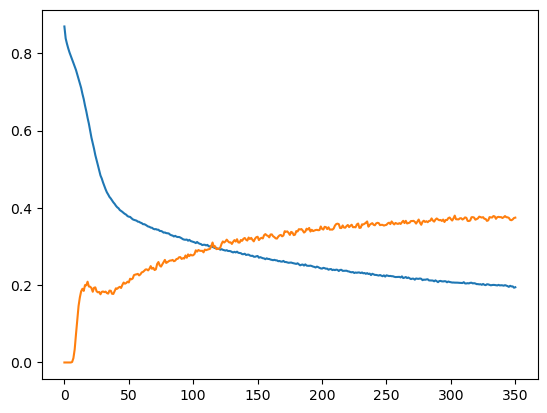

 29%|██▉       | 352/1200 [01:06<01:29,  9.51it/s]

Epoch 351/1200 - loss: 0.1946836163600286, f1: 0.37482590513791203


 30%|██▉       | 359/1200 [01:07<01:42,  8.22it/s]

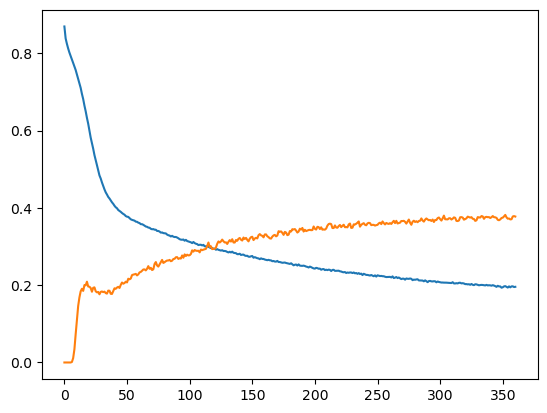

 30%|███       | 363/1200 [01:08<01:28,  9.50it/s]

Epoch 361/1200 - loss: 0.19577105840047201, f1: 0.37770122119450267


 31%|███       | 369/1200 [01:08<01:10, 11.86it/s]

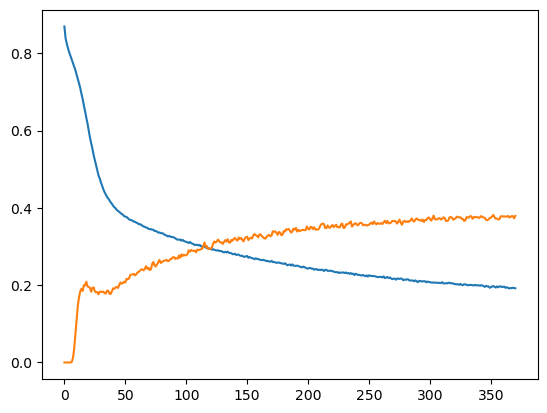

 31%|███       | 371/1200 [01:08<01:14, 11.20it/s]

Epoch 371/1200 - loss: 0.19213487207889557, f1: 0.3794147958366021


 32%|███▏      | 379/1200 [01:09<01:10, 11.59it/s]

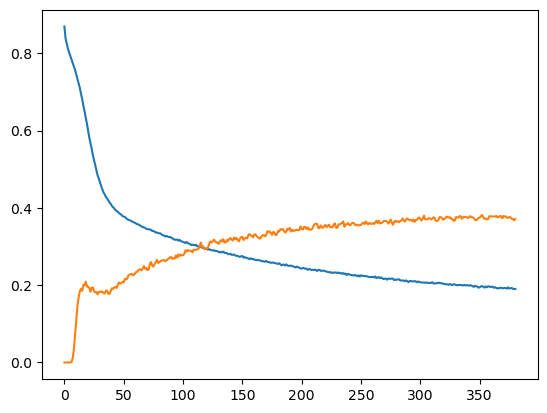

 32%|███▏      | 383/1200 [01:09<01:11, 11.38it/s]

Epoch 381/1200 - loss: 0.19023355344931284, f1: 0.3710312313980194


 32%|███▏      | 389/1200 [01:10<01:09, 11.68it/s]

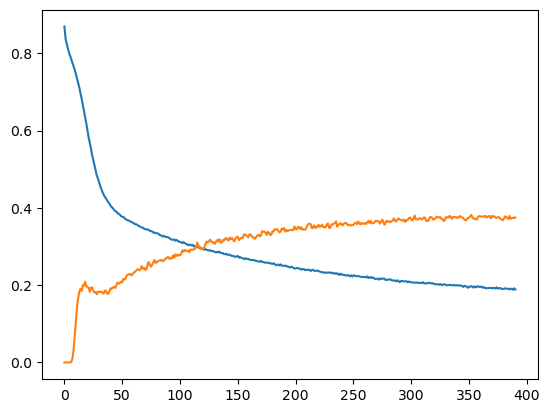

 33%|███▎      | 393/1200 [01:10<01:09, 11.69it/s]

Epoch 391/1200 - loss: 0.18883444120486578, f1: 0.375433753753001


 33%|███▎      | 399/1200 [01:11<01:07, 11.94it/s]

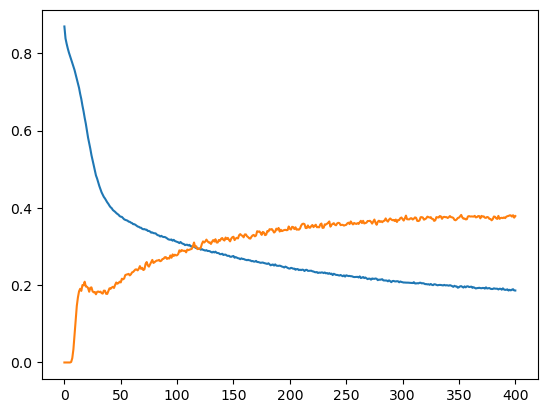

 34%|███▎      | 403/1200 [01:11<01:08, 11.65it/s]

Epoch 401/1200 - loss: 0.1862398311495781, f1: 0.37890006334554


 34%|███▍      | 409/1200 [01:12<01:31,  8.67it/s]

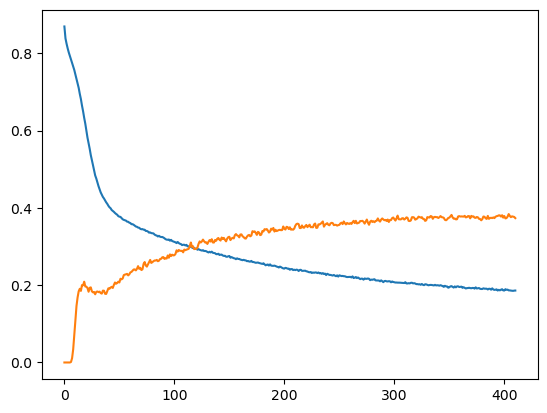

 34%|███▍      | 413/1200 [01:12<01:26,  9.08it/s]

Epoch 411/1200 - loss: 0.18615700552860895, f1: 0.37360434695393197


 35%|███▍      | 419/1200 [01:13<01:18,  9.99it/s]

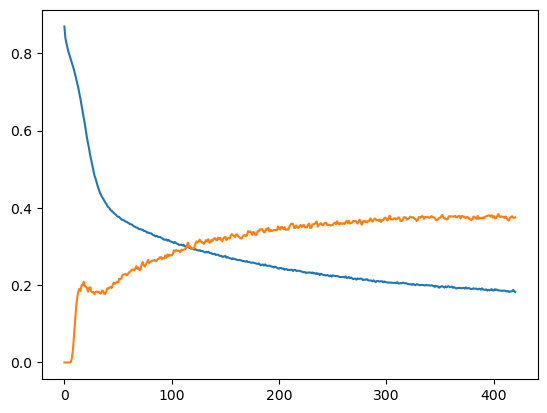

 35%|███▌      | 423/1200 [01:13<01:11, 10.85it/s]

Epoch 421/1200 - loss: 0.18252962082624435, f1: 0.3757126215910017


 36%|███▌      | 429/1200 [01:14<01:03, 12.19it/s]

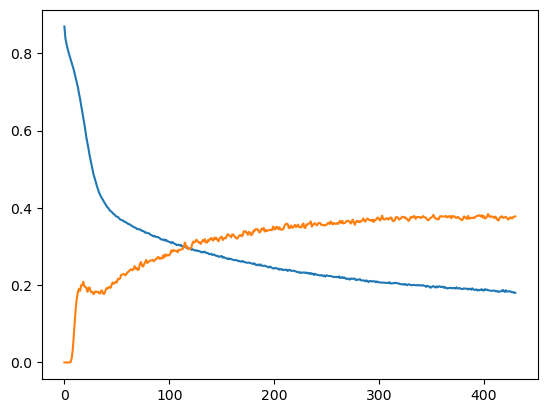

 36%|███▌      | 433/1200 [01:14<01:04, 11.82it/s]

Epoch 431/1200 - loss: 0.18051488449176153, f1: 0.3782852676219325


 37%|███▋      | 439/1200 [01:15<00:58, 13.12it/s]

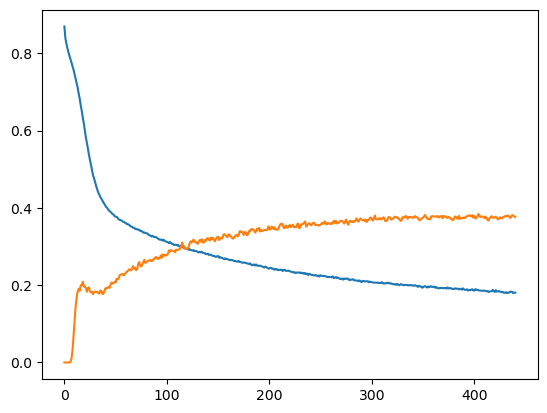

 37%|███▋      | 443/1200 [01:15<01:02, 12.13it/s]

Epoch 441/1200 - loss: 0.18093550205230713, f1: 0.37649162099408773


 37%|███▋      | 449/1200 [01:15<00:59, 12.61it/s]

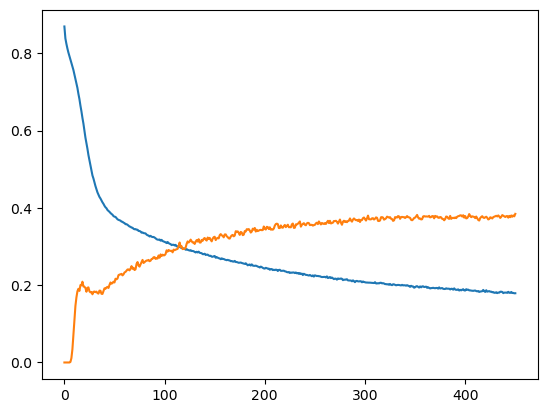

Epoch 451/1200 - loss: 0.17919012904167175, f1: 0.3845696627931263


 38%|███▊      | 459/1200 [01:17<01:30,  8.21it/s]

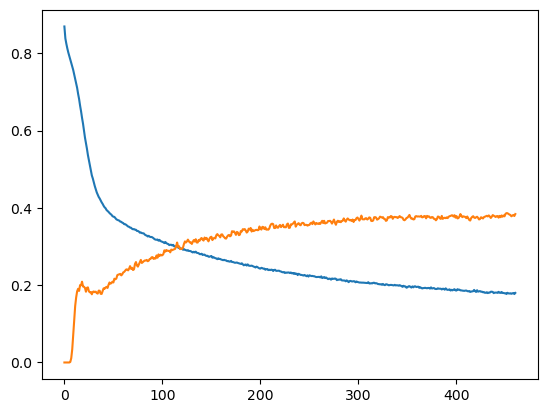

 39%|███▊      | 463/1200 [01:18<01:19,  9.26it/s]

Epoch 461/1200 - loss: 0.17994239429632822, f1: 0.38411158522575556


 39%|███▉      | 469/1200 [01:18<01:07, 10.89it/s]

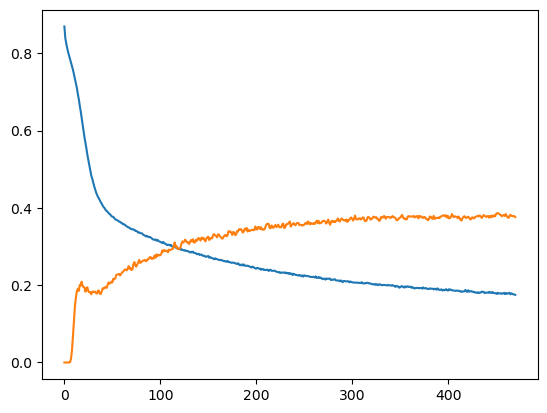

 39%|███▉      | 473/1200 [01:19<01:07, 10.79it/s]

Epoch 471/1200 - loss: 0.17514988034963608, f1: 0.3762400096055787


 40%|███▉      | 479/1200 [01:19<01:10, 10.17it/s]

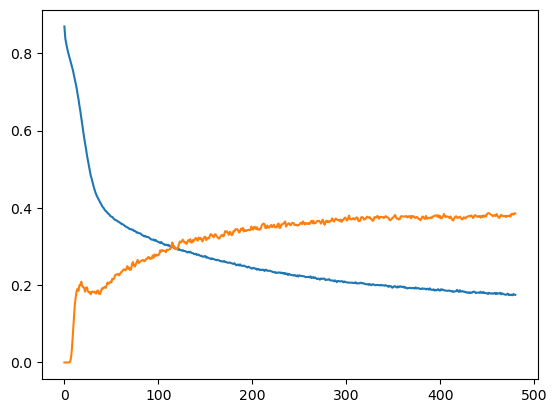

 40%|████      | 483/1200 [01:20<01:06, 10.86it/s]

Epoch 481/1200 - loss: 0.17503133664528528, f1: 0.3856177310552763


 41%|████      | 489/1200 [01:20<00:58, 12.22it/s]

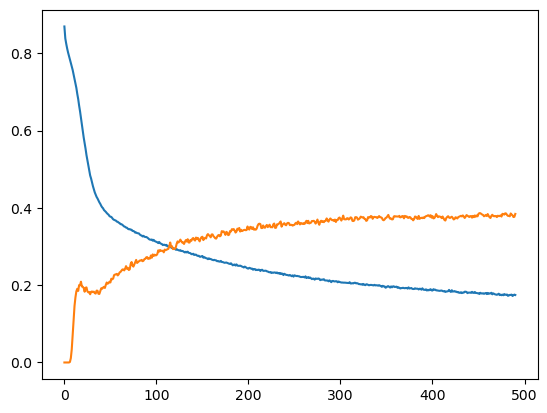

 41%|████      | 491/1200 [01:20<01:01, 11.56it/s]

Epoch 491/1200 - loss: 0.17469000816345215, f1: 0.38447568683670996


 42%|████▏     | 499/1200 [01:22<02:10,  5.38it/s]

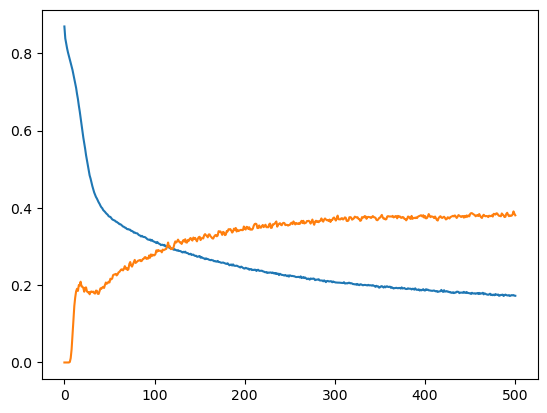

 42%|████▏     | 502/1200 [01:22<01:46,  6.53it/s]

Epoch 501/1200 - loss: 0.172619399925073, f1: 0.38082672559578246


 42%|████▎     | 510/1200 [01:23<01:07, 10.16it/s]

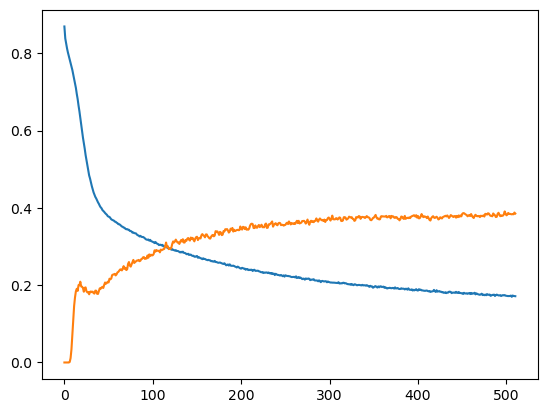

 43%|████▎     | 512/1200 [01:23<01:09,  9.89it/s]

Epoch 511/1200 - loss: 0.17154715458552042, f1: 0.3853857147722807


 43%|████▎     | 520/1200 [01:24<00:55, 12.22it/s]

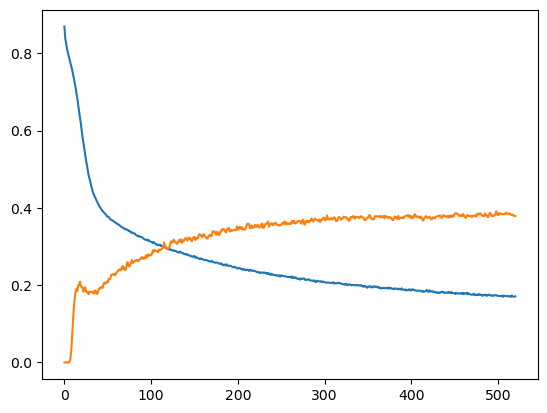

 44%|████▎     | 522/1200 [01:24<01:10,  9.68it/s]

Epoch 521/1200 - loss: 0.1711323137084643, f1: 0.37908120004056833


 44%|████▍     | 530/1200 [01:25<00:54, 12.19it/s]

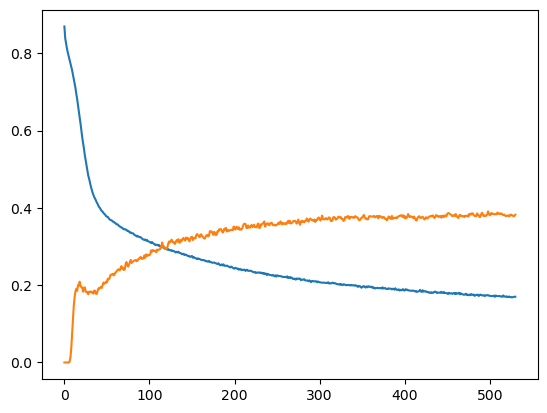

 44%|████▍     | 532/1200 [01:25<00:59, 11.21it/s]

Epoch 531/1200 - loss: 0.17006989816824594, f1: 0.3823671786112215


 45%|████▌     | 540/1200 [01:26<00:54, 12.02it/s]

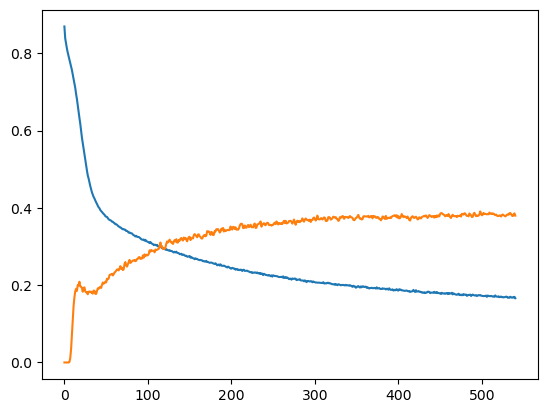

 45%|████▌     | 542/1200 [01:26<01:09,  9.44it/s]

Epoch 541/1200 - loss: 0.16640075792868933, f1: 0.38001483028268035


 46%|████▌     | 550/1200 [01:26<00:53, 12.18it/s]

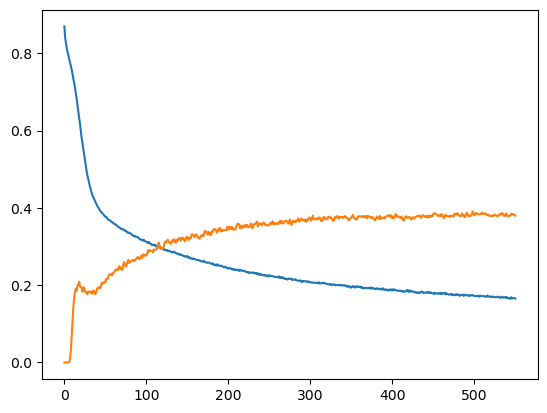

 46%|████▌     | 552/1200 [01:27<00:56, 11.43it/s]

Epoch 551/1200 - loss: 0.1654905378818512, f1: 0.37967293271766983


 47%|████▋     | 560/1200 [01:27<00:50, 12.64it/s]

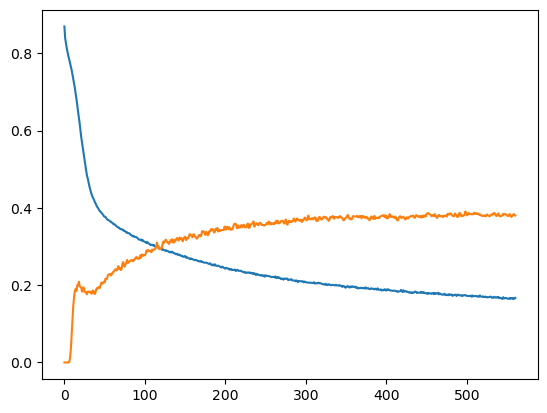

 47%|████▋     | 562/1200 [01:27<00:56, 11.37it/s]

Epoch 561/1200 - loss: 0.16699311385552087, f1: 0.3804933553630267


 48%|████▊     | 570/1200 [01:28<00:58, 10.84it/s]

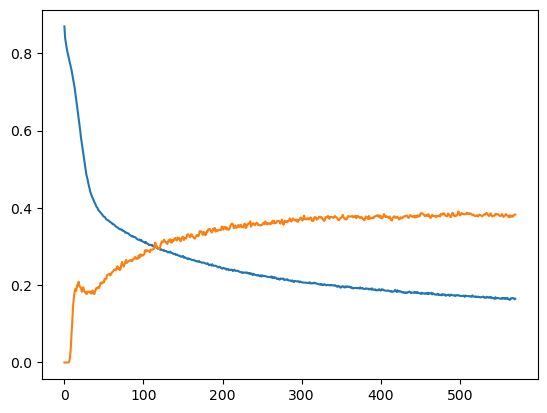

 48%|████▊     | 572/1200 [01:28<01:01, 10.18it/s]

Epoch 571/1200 - loss: 0.16475476821263632, f1: 0.3827601222631962


 48%|████▊     | 580/1200 [01:29<00:54, 11.34it/s]

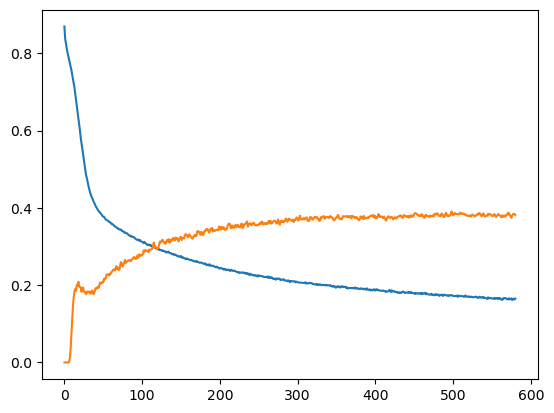

 48%|████▊     | 582/1200 [01:29<00:58, 10.52it/s]

Epoch 581/1200 - loss: 0.16506475458542505, f1: 0.38158116605016557


 49%|████▉     | 590/1200 [01:30<00:55, 11.03it/s]

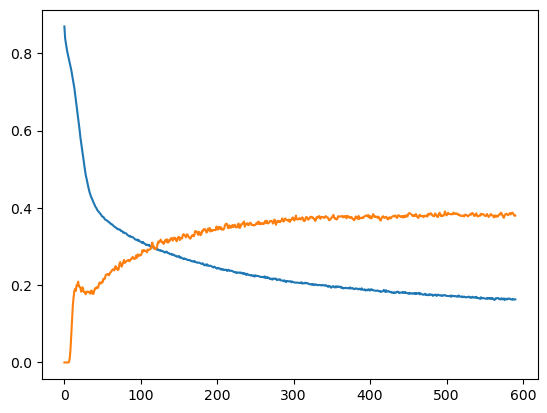

 49%|████▉     | 592/1200 [01:30<00:58, 10.42it/s]

Epoch 591/1200 - loss: 0.16322164237499237, f1: 0.38021844266995275


 50%|█████     | 600/1200 [01:31<00:49, 12.15it/s]

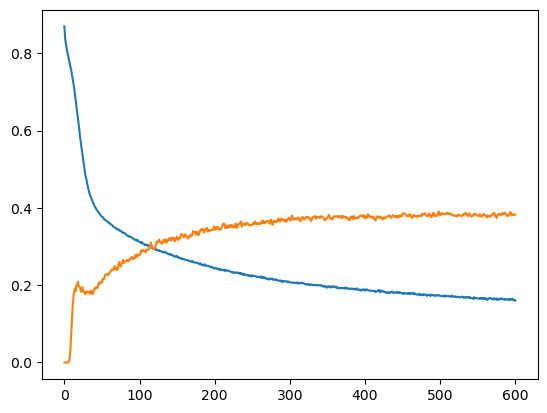

 50%|█████     | 602/1200 [01:31<00:56, 10.57it/s]

Epoch 601/1200 - loss: 0.16050888349612555, f1: 0.3831340642374593


 51%|█████     | 610/1200 [01:32<00:55, 10.61it/s]

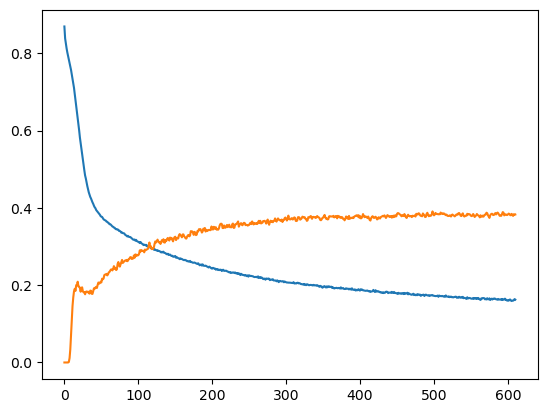

 51%|█████     | 614/1200 [01:32<00:58, 10.03it/s]

Epoch 611/1200 - loss: 0.16261924554904303, f1: 0.38297462999280923


 52%|█████▏    | 620/1200 [01:33<00:49, 11.79it/s]

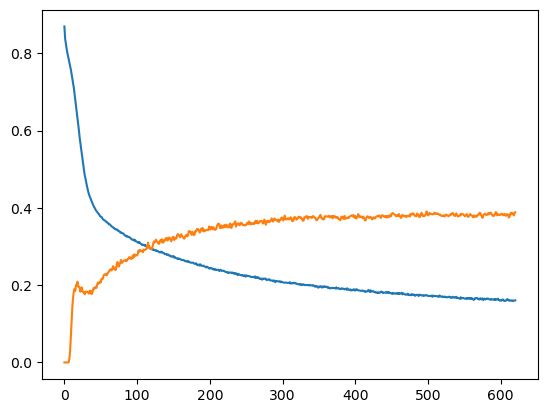

 52%|█████▏    | 622/1200 [01:33<00:54, 10.54it/s]

Epoch 621/1200 - loss: 0.1607781102259954, f1: 0.38891985227171066


 52%|█████▎    | 630/1200 [01:34<00:45, 12.66it/s]

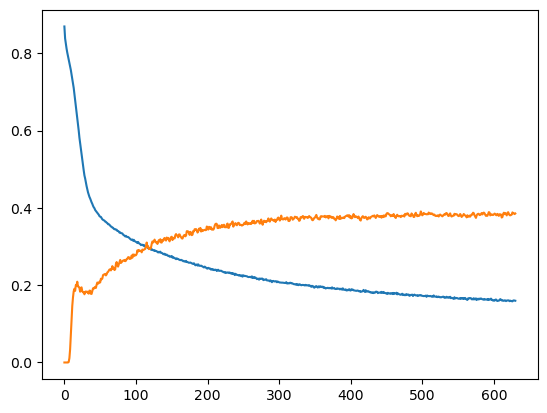

 53%|█████▎    | 632/1200 [01:34<00:50, 11.23it/s]

Epoch 631/1200 - loss: 0.159790409108003, f1: 0.38552864371775886


 53%|█████▎    | 640/1200 [01:35<00:52, 10.68it/s]

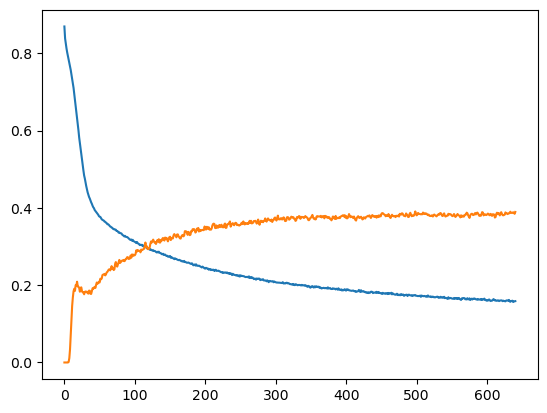

 54%|█████▎    | 642/1200 [01:35<00:55, 10.02it/s]

Epoch 641/1200 - loss: 0.15873296310504278, f1: 0.3894816331804414


 54%|█████▍    | 650/1200 [01:36<00:46, 11.83it/s]

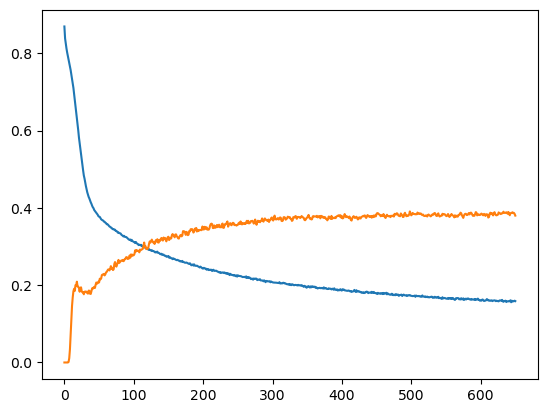

 54%|█████▍    | 652/1200 [01:36<00:50, 10.86it/s]

Epoch 651/1200 - loss: 0.1588224545121193, f1: 0.38006403273499756


 55%|█████▌    | 660/1200 [01:36<00:46, 11.66it/s]

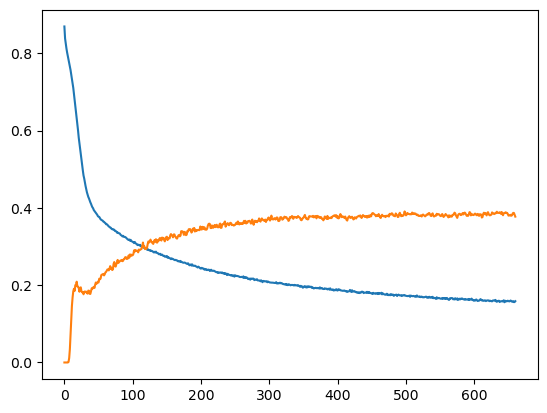

 55%|█████▌    | 662/1200 [01:37<00:50, 10.62it/s]

Epoch 661/1200 - loss: 0.15863044808308283, f1: 0.3774532833871994


 56%|█████▌    | 670/1200 [01:37<00:42, 12.52it/s]

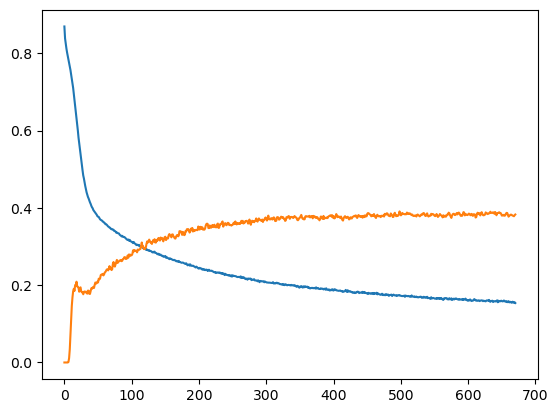

 56%|█████▌    | 672/1200 [01:38<00:46, 11.34it/s]

Epoch 671/1200 - loss: 0.15393415093421936, f1: 0.3829224891976949


 57%|█████▋    | 680/1200 [01:38<00:43, 11.87it/s]

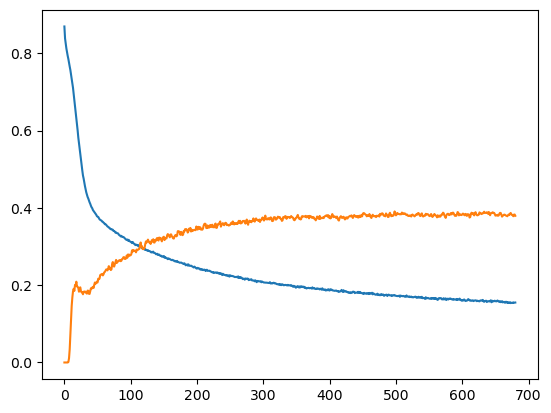

 57%|█████▋    | 682/1200 [01:38<00:46, 11.05it/s]

Epoch 681/1200 - loss: 0.15512876212596893, f1: 0.3796096340635081


 57%|█████▊    | 690/1200 [01:39<00:47, 10.74it/s]

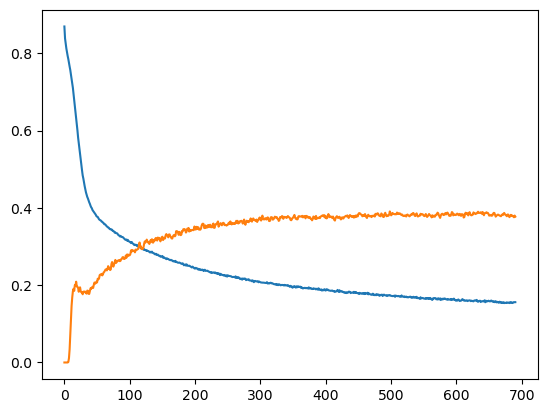

 58%|█████▊    | 692/1200 [01:39<00:49, 10.24it/s]

Epoch 691/1200 - loss: 0.15606545160214105, f1: 0.37746152017912593


 58%|█████▊    | 700/1200 [01:40<00:42, 11.82it/s]

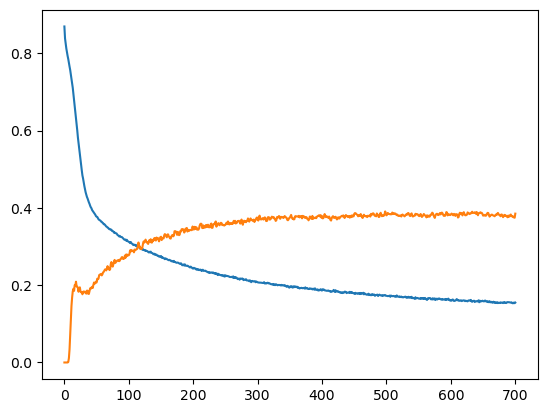

 58%|█████▊    | 702/1200 [01:40<00:47, 10.55it/s]

Epoch 701/1200 - loss: 0.15493627885977426, f1: 0.3851777920733886


 59%|█████▉    | 710/1200 [01:41<00:47, 10.42it/s]

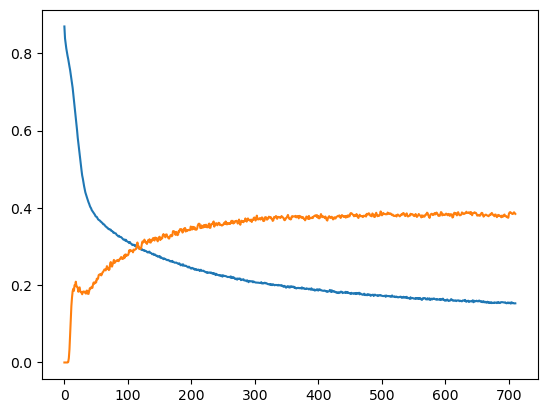

 59%|█████▉    | 712/1200 [01:41<00:47, 10.20it/s]

Epoch 711/1200 - loss: 0.15305301547050476, f1: 0.3845625472903102


 60%|██████    | 720/1200 [01:43<02:29,  3.22it/s]

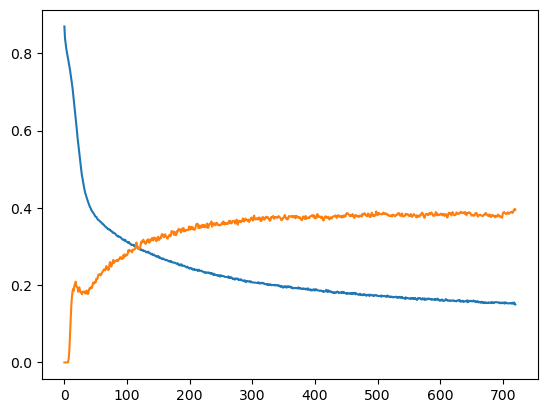

 60%|██████    | 722/1200 [01:44<01:51,  4.31it/s]

Epoch 721/1200 - loss: 0.1501630668838819, f1: 0.395252955987806


 61%|██████    | 730/1200 [01:44<00:57,  8.17it/s]

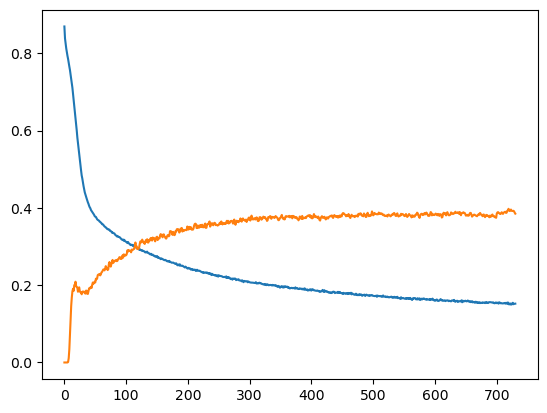

 61%|██████    | 733/1200 [01:45<00:51,  9.04it/s]

Epoch 731/1200 - loss: 0.15220553427934647, f1: 0.3851609370625544


 62%|██████▏   | 739/1200 [01:45<00:43, 10.69it/s]

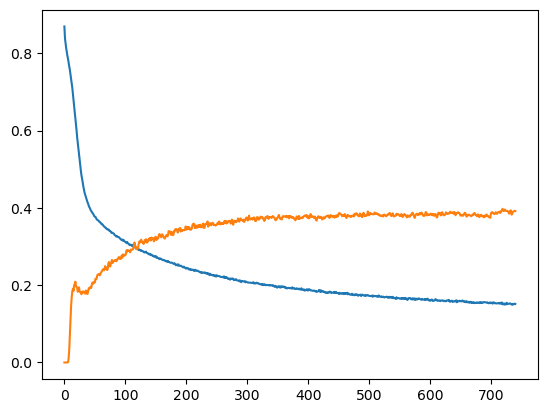

 62%|██████▏   | 743/1200 [01:46<00:42, 10.75it/s]

Epoch 741/1200 - loss: 0.1515082630018393, f1: 0.39171812063572464


 62%|██████▏   | 749/1200 [01:46<00:37, 12.02it/s]

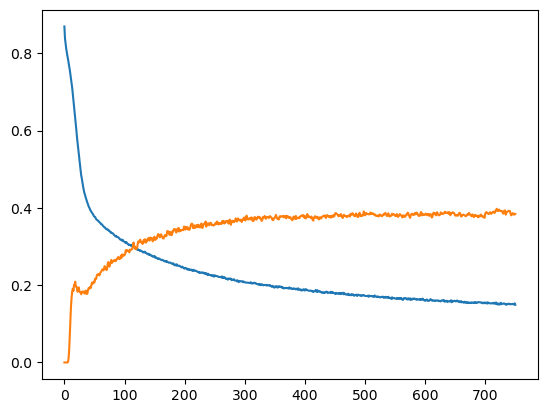

 63%|██████▎   | 753/1200 [01:47<00:37, 11.82it/s]

Epoch 751/1200 - loss: 0.14925110464294752, f1: 0.38432263124254773


 63%|██████▎   | 759/1200 [01:47<00:38, 11.60it/s]

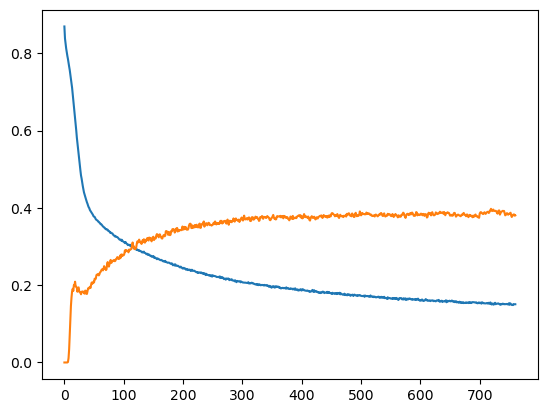

 64%|██████▎   | 763/1200 [01:47<00:37, 11.55it/s]

Epoch 761/1200 - loss: 0.1506662592291832, f1: 0.38065143736557877


 64%|██████▍   | 769/1200 [01:48<00:37, 11.43it/s]

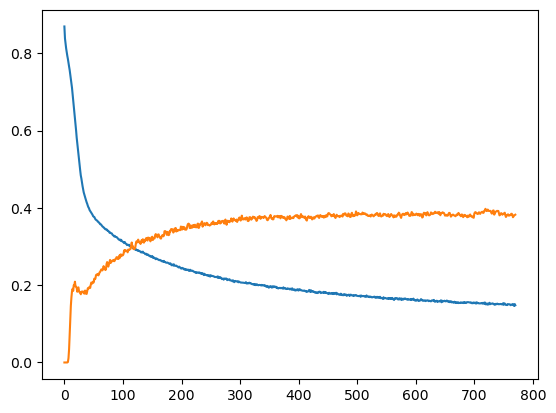

 64%|██████▍   | 773/1200 [01:48<00:37, 11.31it/s]

Epoch 771/1200 - loss: 0.14810412004590034, f1: 0.38245338584508015


 65%|██████▍   | 779/1200 [01:49<00:35, 11.71it/s]

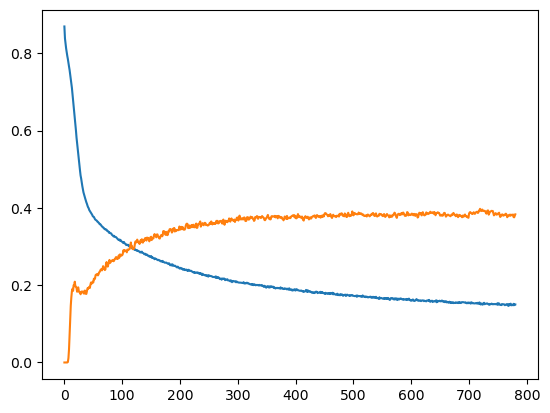

 65%|██████▌   | 783/1200 [01:49<00:42,  9.81it/s]

Epoch 781/1200 - loss: 0.15012467031677565, f1: 0.38336988877326234


 66%|██████▌   | 789/1200 [01:50<00:36, 11.30it/s]

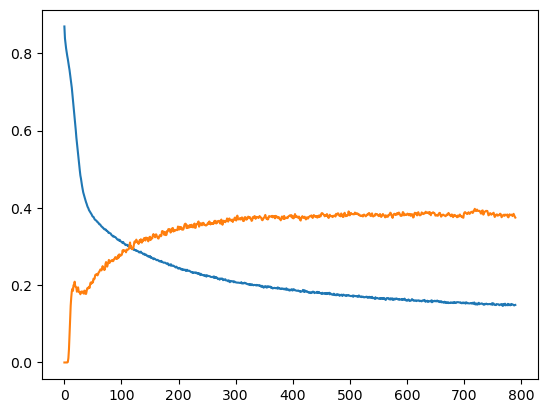

 66%|██████▌   | 793/1200 [01:50<00:37, 10.84it/s]

Epoch 791/1200 - loss: 0.14894055699308714, f1: 0.37494964337018694


 67%|██████▋   | 799/1200 [01:51<00:32, 12.29it/s]

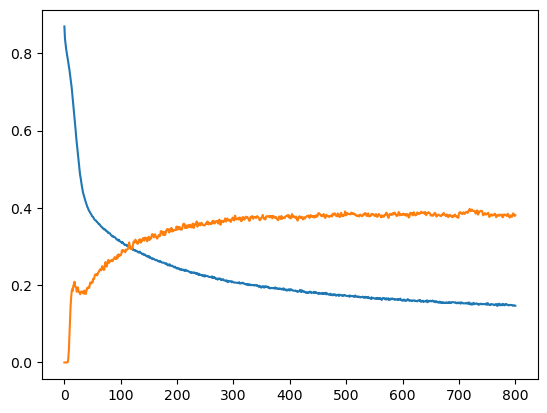

 67%|██████▋   | 803/1200 [01:51<00:33, 11.91it/s]

Epoch 801/1200 - loss: 0.14680749053756395, f1: 0.3810298651306193


 67%|██████▋   | 809/1200 [01:52<00:34, 11.23it/s]

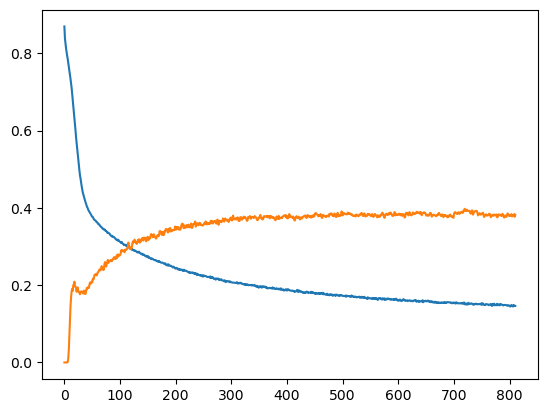

 68%|██████▊   | 813/1200 [01:52<00:34, 11.34it/s]

Epoch 811/1200 - loss: 0.14643261581659317, f1: 0.382259891150542


 68%|██████▊   | 819/1200 [01:52<00:31, 12.25it/s]

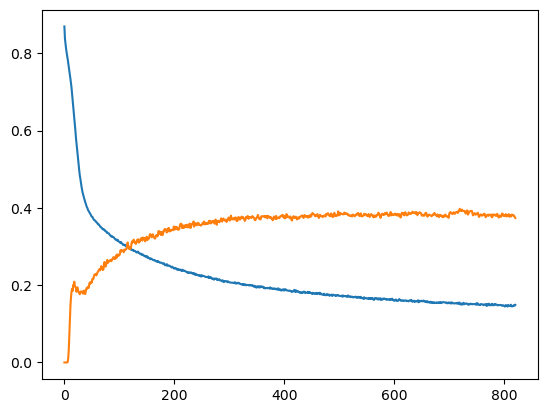

 69%|██████▊   | 823/1200 [01:53<00:35, 10.65it/s]

Epoch 821/1200 - loss: 0.14907442157467207, f1: 0.3738527531158756


 69%|██████▉   | 829/1200 [01:53<00:31, 11.65it/s]

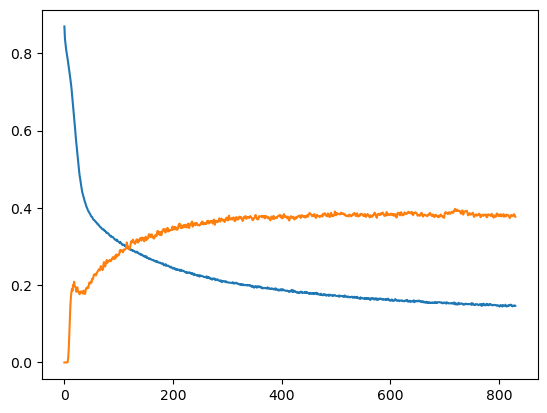

 69%|██████▉   | 833/1200 [01:54<00:33, 10.85it/s]

Epoch 831/1200 - loss: 0.14654432982206345, f1: 0.37693267673151964


 70%|██████▉   | 839/1200 [01:54<00:32, 11.15it/s]

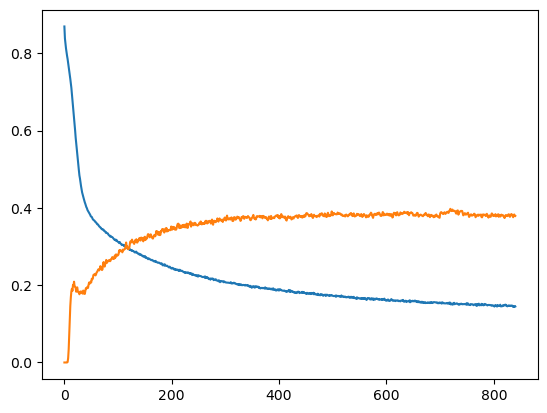

 70%|███████   | 843/1200 [01:55<00:35, 10.12it/s]

Epoch 841/1200 - loss: 0.14490493883689246, f1: 0.3792616009001625


 71%|███████   | 849/1200 [01:55<00:31, 11.26it/s]

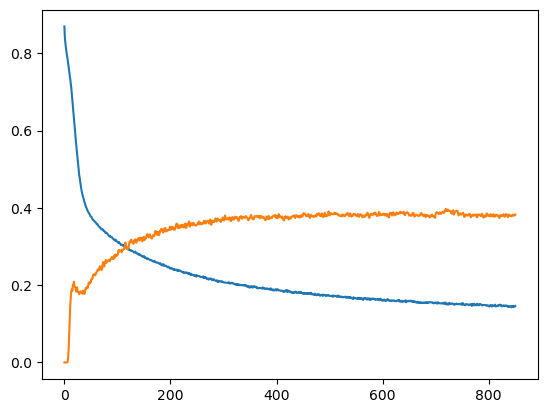

 71%|███████   | 853/1200 [01:56<00:30, 11.45it/s]

Epoch 851/1200 - loss: 0.14608658477663994, f1: 0.38268735328610426


 72%|███████▏  | 859/1200 [01:56<00:26, 12.74it/s]

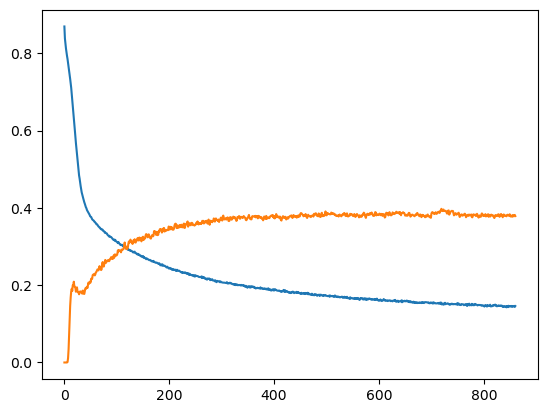

 72%|███████▏  | 861/1200 [01:56<00:28, 11.79it/s]

Epoch 861/1200 - loss: 0.14602884277701378, f1: 0.37882343198959256


 72%|███████▏  | 869/1200 [01:57<00:29, 11.20it/s]

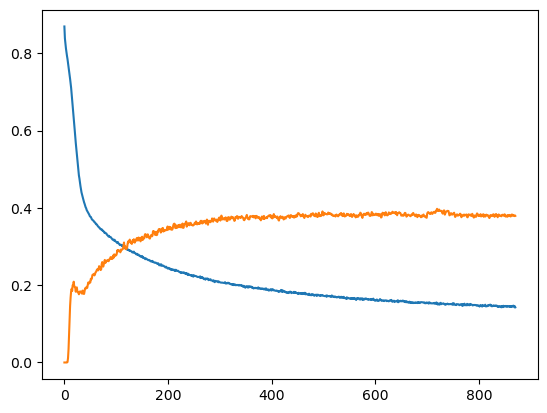

 73%|███████▎  | 873/1200 [01:57<00:29, 10.94it/s]

Epoch 871/1200 - loss: 0.1426838052769502, f1: 0.37940328554621383


 73%|███████▎  | 879/1200 [01:58<00:27, 11.66it/s]

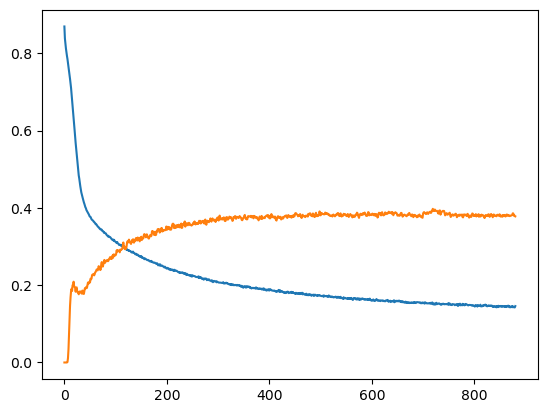

 74%|███████▎  | 883/1200 [01:58<00:27, 11.69it/s]

Epoch 881/1200 - loss: 0.14590842028458914, f1: 0.3780938358663529


 74%|███████▍  | 889/1200 [01:59<00:23, 12.97it/s]

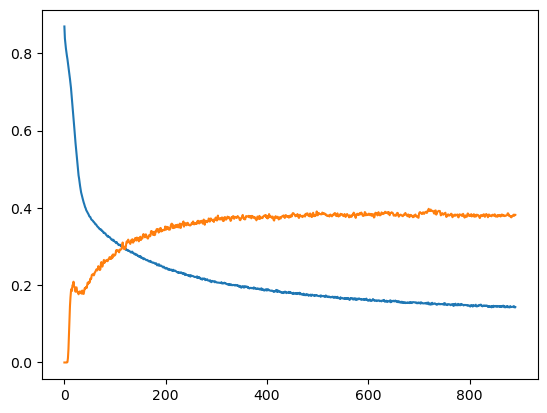

 74%|███████▍  | 893/1200 [01:59<00:25, 11.82it/s]

Epoch 891/1200 - loss: 0.1433111528555552, f1: 0.38210068301381617


 75%|███████▍  | 899/1200 [02:00<00:23, 12.63it/s]

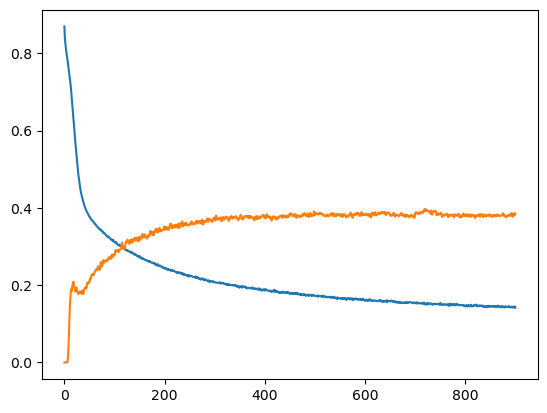

 75%|███████▌  | 903/1200 [02:00<00:29,  9.96it/s]

Epoch 901/1200 - loss: 0.1414585808912913, f1: 0.38545520426140334


 76%|███████▌  | 909/1200 [02:01<00:26, 10.89it/s]

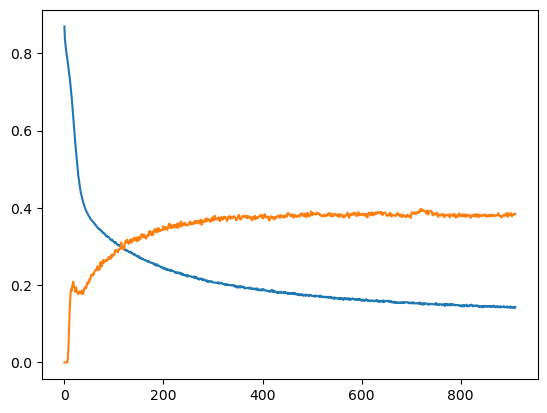

 76%|███████▌  | 913/1200 [02:01<00:25, 11.09it/s]

Epoch 911/1200 - loss: 0.14343923702836037, f1: 0.38389891746847826


 77%|███████▋  | 919/1200 [02:01<00:23, 12.11it/s]

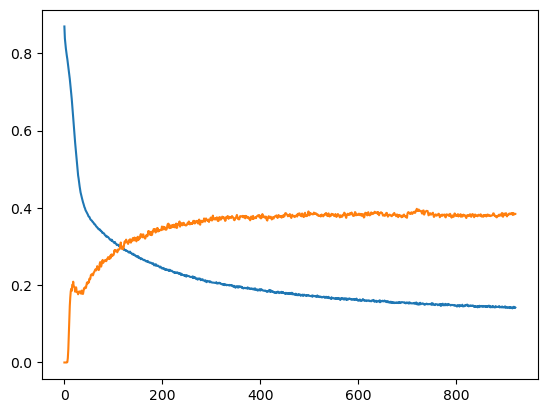

 77%|███████▋  | 923/1200 [02:02<00:22, 12.05it/s]

Epoch 921/1200 - loss: 0.14224573348959288, f1: 0.3845625014743135


 77%|███████▋  | 929/1200 [02:02<00:21, 12.36it/s]

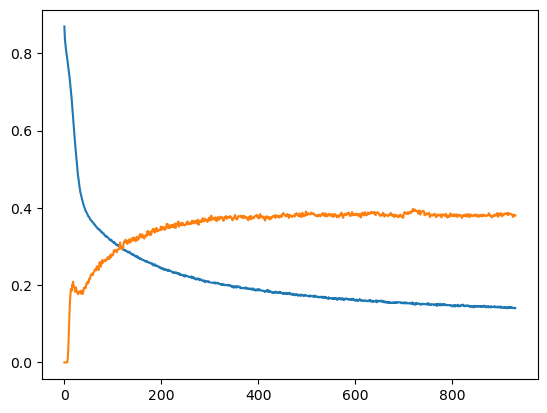

 78%|███████▊  | 933/1200 [02:03<00:23, 11.37it/s]

Epoch 931/1200 - loss: 0.14078693464398384, f1: 0.3801930714463896


 78%|███████▊  | 939/1200 [02:03<00:25, 10.07it/s]

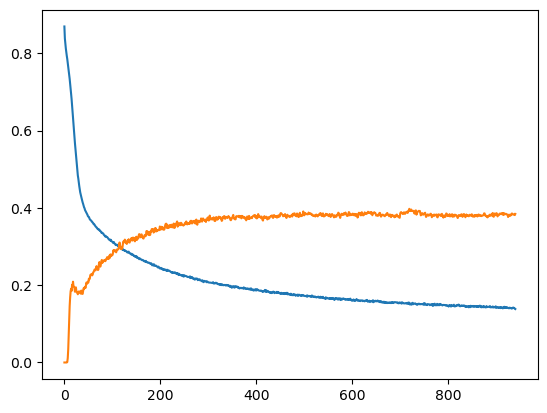

 79%|███████▊  | 943/1200 [02:04<00:25, 10.23it/s]

Epoch 941/1200 - loss: 0.13828649868567786, f1: 0.3844957493330686


 79%|███████▉  | 949/1200 [02:04<00:21, 11.50it/s]

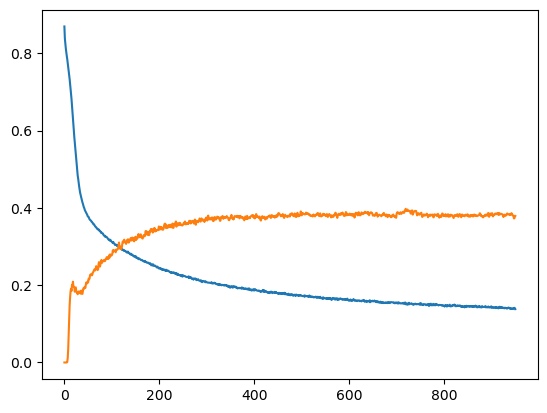

 79%|███████▉  | 953/1200 [02:04<00:21, 11.38it/s]

Epoch 951/1200 - loss: 0.13814047972361246, f1: 0.3791606674547968


 80%|███████▉  | 959/1200 [02:05<00:20, 11.69it/s]

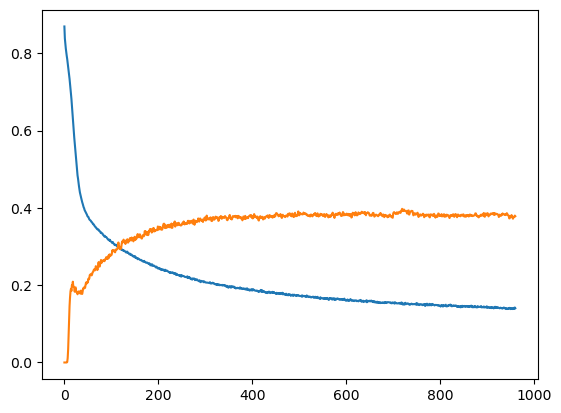

 80%|████████  | 963/1200 [02:05<00:23, 10.03it/s]

Epoch 961/1200 - loss: 0.14041504512230554, f1: 0.3785535651972136


 81%|████████  | 969/1200 [02:06<00:21, 10.89it/s]

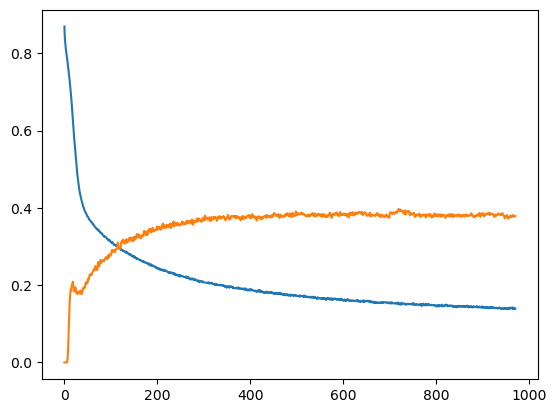

 81%|████████  | 973/1200 [02:06<00:20, 11.05it/s]

Epoch 971/1200 - loss: 0.13923830538988113, f1: 0.3788263944782697


 82%|████████▏ | 979/1200 [02:07<00:18, 12.17it/s]

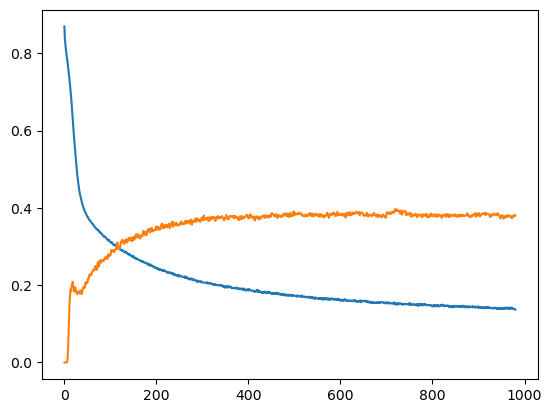

 82%|████████▏ | 983/1200 [02:07<00:18, 11.45it/s]

Epoch 981/1200 - loss: 0.13667573779821396, f1: 0.38097140415182495


 82%|████████▏ | 989/1200 [02:08<00:16, 12.69it/s]

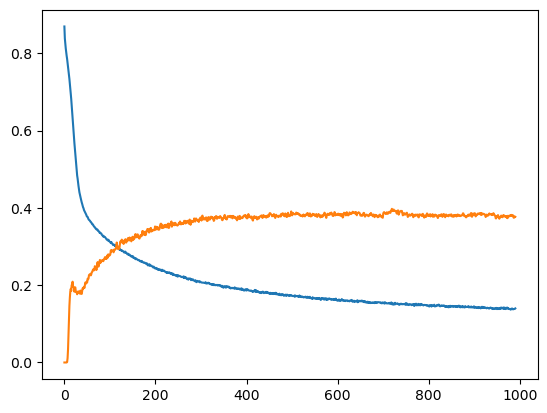

 83%|████████▎ | 993/1200 [02:08<00:17, 11.77it/s]

Epoch 991/1200 - loss: 0.1399013102054596, f1: 0.3770571402242938


 83%|████████▎ | 999/1200 [02:09<00:19, 10.20it/s]

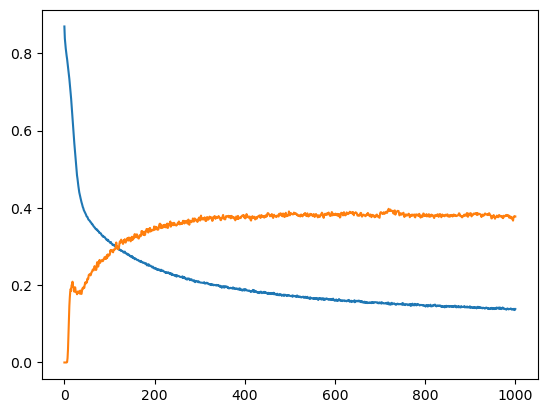

 84%|████████▎ | 1003/1200 [02:09<00:18, 10.74it/s]

Epoch 1001/1200 - loss: 0.138257447630167, f1: 0.3776737201386997


 84%|████████▍ | 1009/1200 [02:09<00:15, 12.36it/s]

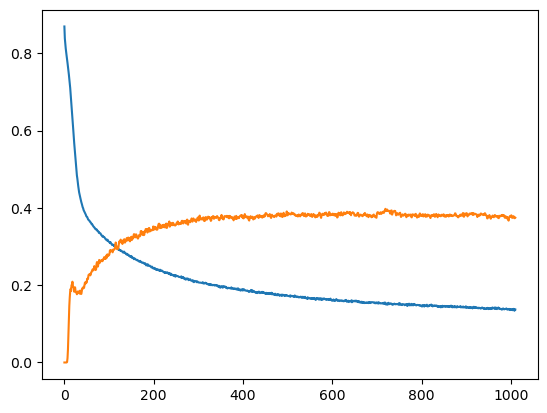

 84%|████████▍ | 1013/1200 [02:10<00:16, 11.48it/s]

Epoch 1011/1200 - loss: 0.13729411115249, f1: 0.3746912189228594


 85%|████████▍ | 1019/1200 [02:10<00:14, 12.37it/s]

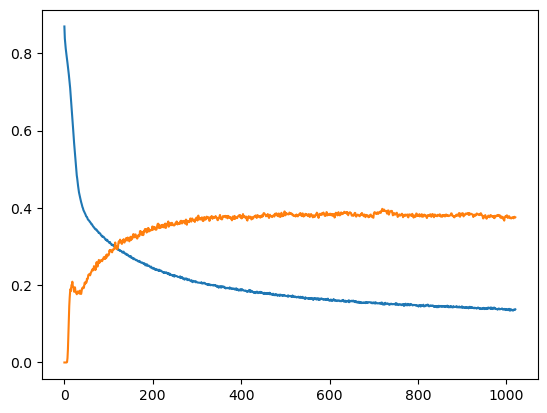

 85%|████████▌ | 1023/1200 [02:11<00:18,  9.75it/s]

Epoch 1021/1200 - loss: 0.1374941828350226, f1: 0.3757211208327591


 86%|████████▌ | 1029/1200 [02:11<00:15, 10.94it/s]

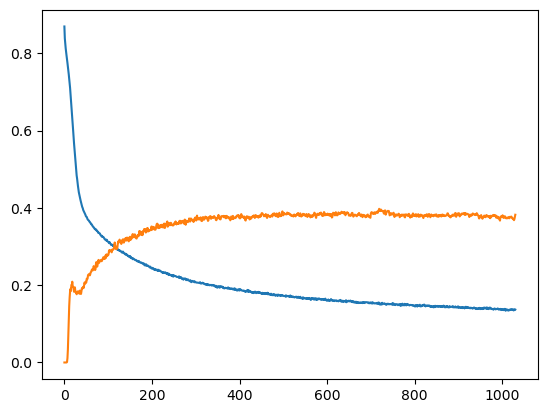

 86%|████████▌ | 1033/1200 [02:12<00:15, 10.93it/s]

Epoch 1031/1200 - loss: 0.13692214464147887, f1: 0.38232717741356714


 87%|████████▋ | 1039/1200 [02:12<00:13, 12.28it/s]

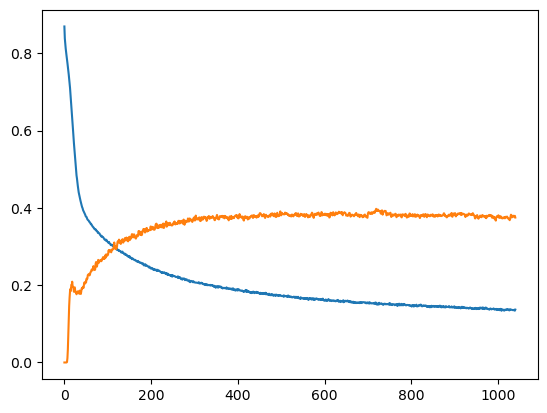

 87%|████████▋ | 1043/1200 [02:13<00:14, 10.63it/s]

Epoch 1041/1200 - loss: 0.1369031729797522, f1: 0.3751081419524379


 87%|████████▋ | 1049/1200 [02:13<00:12, 12.14it/s]

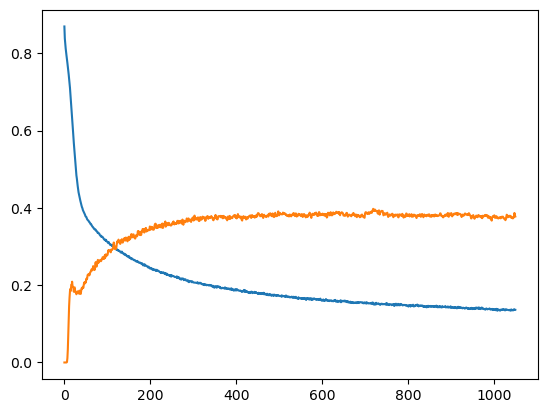

 88%|████████▊ | 1053/1200 [02:13<00:13, 11.06it/s]

Epoch 1051/1200 - loss: 0.13635073602199554, f1: 0.37781735718133047


 88%|████████▊ | 1059/1200 [02:14<00:11, 11.76it/s]

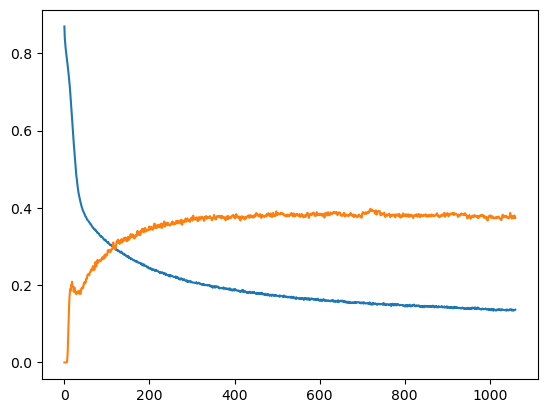

 89%|████████▊ | 1063/1200 [02:14<00:12, 11.38it/s]

Epoch 1061/1200 - loss: 0.13669940332571665, f1: 0.37421812045837854


 89%|████████▉ | 1069/1200 [02:15<00:12, 10.60it/s]

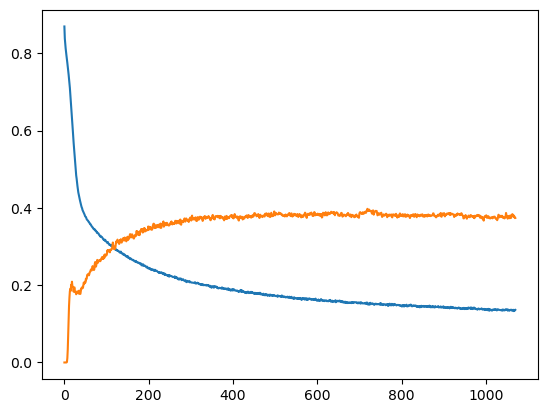

 89%|████████▉ | 1073/1200 [02:15<00:12, 10.54it/s]

Epoch 1071/1200 - loss: 0.1360973839958509, f1: 0.3740086793607711


 90%|████████▉ | 1079/1200 [02:16<00:10, 11.64it/s]

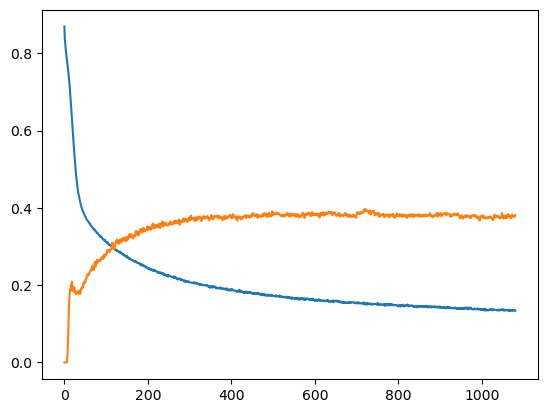

 90%|█████████ | 1083/1200 [02:16<00:10, 11.17it/s]

Epoch 1081/1200 - loss: 0.13403775294621786, f1: 0.38130479988846167


 91%|█████████ | 1089/1200 [02:17<00:10, 10.71it/s]

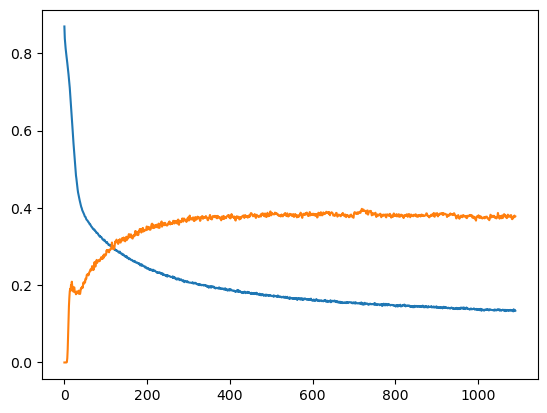

 91%|█████████ | 1093/1200 [02:17<00:10, 10.51it/s]

Epoch 1091/1200 - loss: 0.13398569325606027, f1: 0.3780113711137866


 92%|█████████▏| 1099/1200 [02:18<00:09, 11.21it/s]

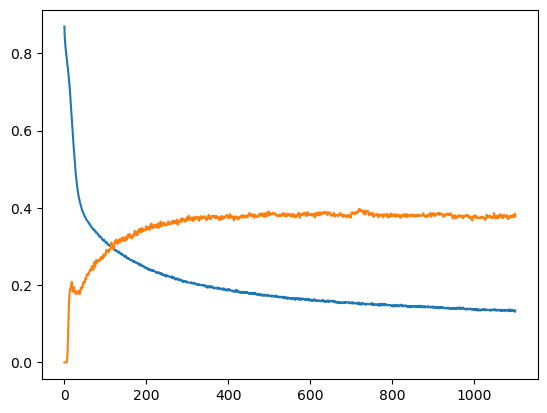

 92%|█████████▏| 1103/1200 [02:18<00:09, 10.78it/s]

Epoch 1101/1200 - loss: 0.13447511941194534, f1: 0.3784192614986166


 92%|█████████▏| 1109/1200 [02:19<00:09,  9.89it/s]

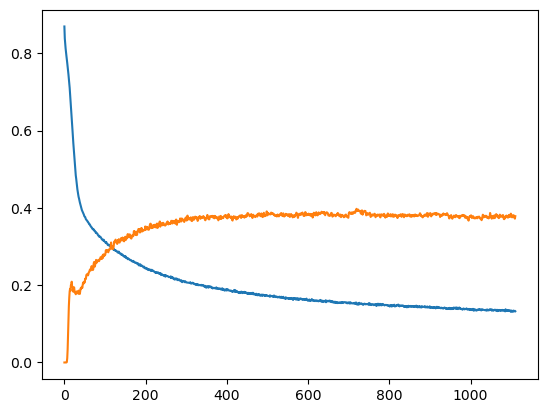

 93%|█████████▎| 1112/1200 [02:19<00:09,  9.55it/s]

Epoch 1111/1200 - loss: 0.13259033237894377, f1: 0.3786101605098535


 93%|█████████▎| 1120/1200 [02:20<00:07, 11.18it/s]

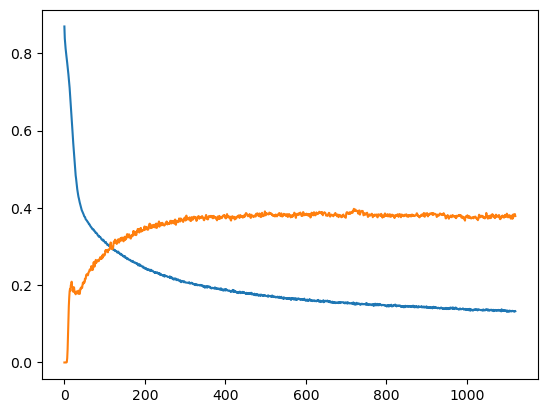

 94%|█████████▎| 1122/1200 [02:20<00:07, 10.48it/s]

Epoch 1121/1200 - loss: 0.13265241558353105, f1: 0.3788716597691103


 94%|█████████▍| 1130/1200 [02:21<00:07,  9.42it/s]

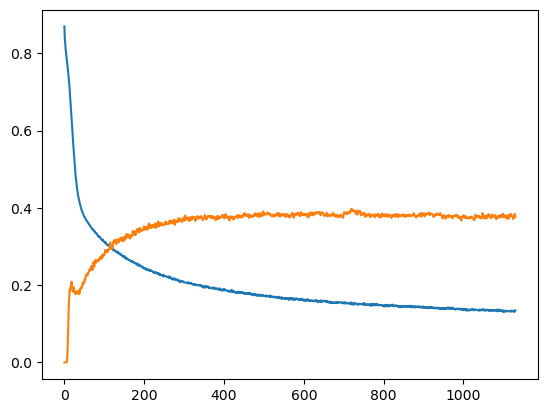

 94%|█████████▍| 1132/1200 [02:21<00:07,  9.30it/s]

Epoch 1131/1200 - loss: 0.13408967355887094, f1: 0.37700596807719505


 95%|█████████▌| 1140/1200 [02:22<00:05, 11.84it/s]

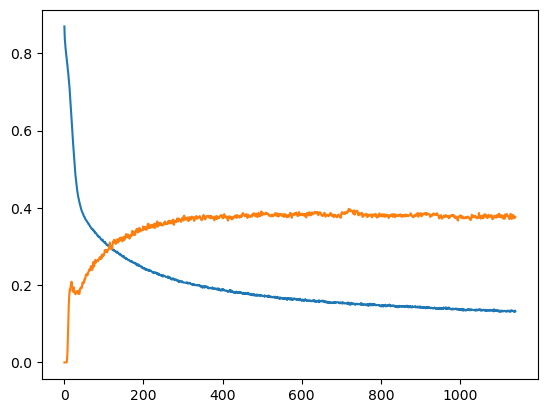

 95%|█████████▌| 1142/1200 [02:22<00:05, 10.99it/s]

Epoch 1141/1200 - loss: 0.13261015340685844, f1: 0.37614314490615997


 96%|█████████▌| 1150/1200 [02:23<00:03, 12.73it/s]

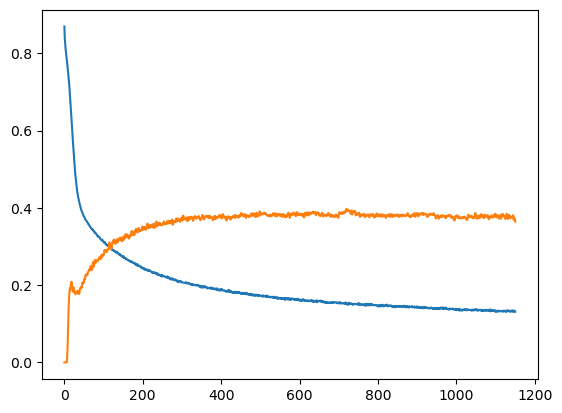

 96%|█████████▌| 1152/1200 [02:23<00:04,  9.76it/s]

Epoch 1151/1200 - loss: 0.13128203277786574, f1: 0.36418941838189034


 97%|█████████▋| 1160/1200 [02:23<00:03, 11.71it/s]

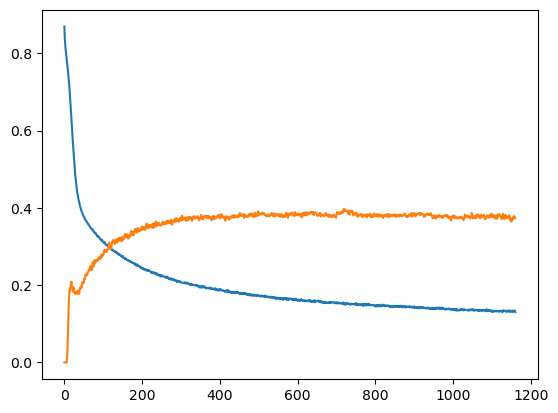

 97%|█████████▋| 1162/1200 [02:24<00:03, 10.64it/s]

Epoch 1161/1200 - loss: 0.13029069701830545, f1: 0.37398287513370543


 98%|█████████▊| 1170/1200 [02:24<00:02, 11.93it/s]

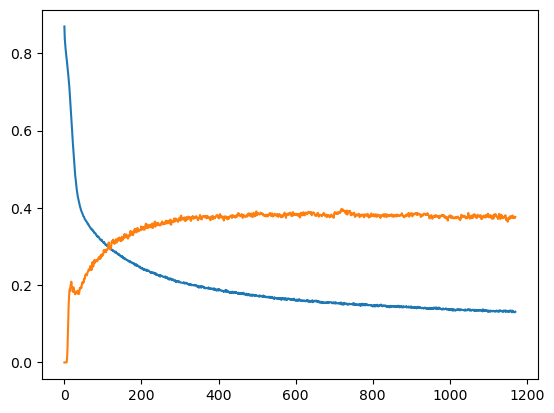

 98%|█████████▊| 1172/1200 [02:25<00:02, 10.78it/s]

Epoch 1171/1200 - loss: 0.13119011372327805, f1: 0.3769548168929444


 98%|█████████▊| 1180/1200 [02:25<00:01, 11.01it/s]

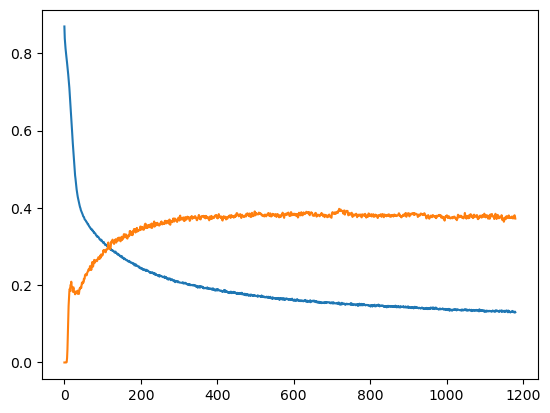

 98%|█████████▊| 1182/1200 [02:26<00:01, 10.44it/s]

Epoch 1181/1200 - loss: 0.1299812744061152, f1: 0.3724125902061902


 99%|█████████▉| 1190/1200 [02:26<00:00, 12.20it/s]

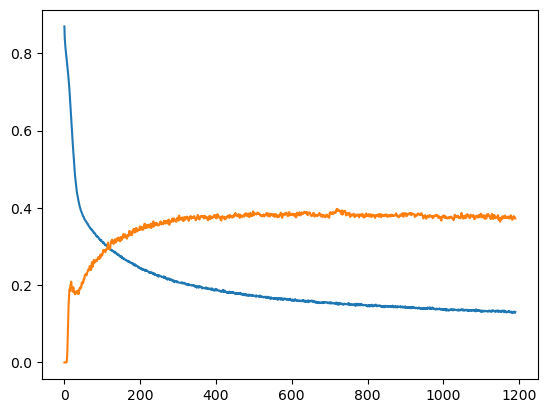

 99%|█████████▉| 1192/1200 [02:26<00:00, 11.40it/s]

Epoch 1191/1200 - loss: 0.13070607806245485, f1: 0.3726898654363679


100%|██████████| 1200/1200 [02:27<00:00,  8.13it/s]


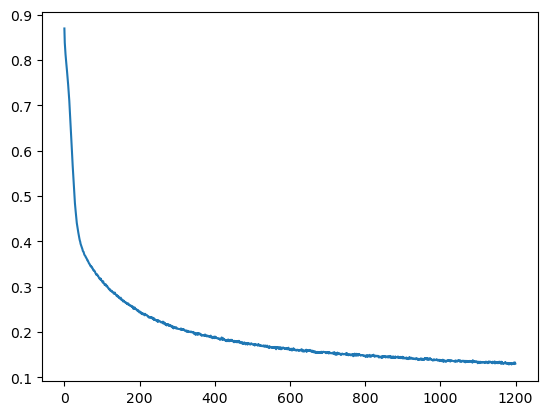

In [10]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []

best_metric = 0

for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_metric = 0
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.where(outputs > 0.75, 1, 0)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        total_metric += f1_score(labels, outputs, average="weighted")

    losses.append(total_loss / len(data_loader))
    metrics.append(total_metric / len(val_loader))
    
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.plot(metrics)
        plt.show()
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}, f1: {metrics[-1]}")

    if metrics[-1] > best_metric:
        best_metric = metrics[-1]
        torch.save(model.state_dict(), "models/hv_classifier.pt")
        
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

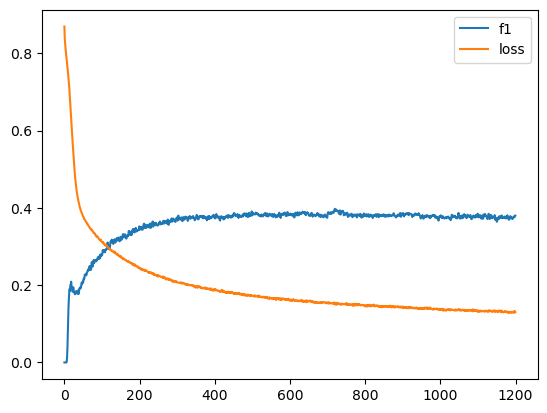

In [11]:
plt.plot(metrics, label="f1")
plt.plot(losses, label="loss")
plt.legend()
plt.show()

In [12]:

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       1.00      0.98      0.99       988
   Self-direction: thought       1.00      0.99      0.99      1395
    Self-direction: action       1.00      0.01      0.02       247
               Stimulation       1.00      0.01      0.02       172
                  Hedonism       1.00      0.99      0.99      1512
               Achievement       1.00      0.17      0.30       610
          Power: dominance       1.00      0.94      0.97       625
          Power: resources       0.00      0.00      0.00       382
                      Face       1.00      0.99      0.99      2000
        Security: personal       1.00      0.98      0.99      1728
        Security: societal       0.99      0.92      0.95       568
                 Tradition       1.00      0.97      0.99      1177
         Conformity: rules       1.00      0.10      0.18       207
 Conformity: interpersonal       1.00      0.22

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
validation_inputs, validation_labels = load_data("datasets/validation_merged.csv")

outputs = model.predict(validation_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(validation_labels, outputs, target_names=df.columns[:-1]))

# save classification report as CSV
report = classification_report(validation_labels, outputs, target_names=df.columns[:-1], output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv("reports/validation_performance.csv")


                            precision    recall  f1-score   support

                    Merged       0.58      0.14      0.23       251
   Self-direction: thought       0.42      0.33      0.37       496
    Self-direction: action       0.00      0.00      0.00       138
               Stimulation       0.00      0.00      0.00       103
                  Hedonism       0.48      0.61      0.54       575
               Achievement       0.00      0.00      0.00       164
          Power: dominance       0.28      0.19      0.23       132
          Power: resources       0.00      0.00      0.00       130
                      Face       0.68      0.63      0.66       759
        Security: personal       0.41      0.26      0.32       488
        Security: societal       0.53      0.33      0.40       172
                 Tradition       0.51      0.29      0.37       455
         Conformity: rules       0.00      0.00      0.00        60
 Conformity: interpersonal       0.50      0.01

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\m

In [ ]:
# save model
torch.save(model.state_dict(), "models/hv_net.pt")